In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from matplotlib import pyplot as plt

import os
import time
from tensorflow import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dense, Embedding, GRU, Bidirectional, Concatenate, Dropout, Layer, Add, LayerNormalization
from keras.utils import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk import edit_distance

from funkcije import *

2023-09-14 11:35:13.370874: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-14 11:35:13.401415: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 11:35:13.853757: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/ivan/.local/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a pl

Kako smo imali problem sa limitacijom memorije graficke karte, koristimo poseban setting koji moze da pomnogne u tom slucaju.

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2023-09-14 11:35:14.960952: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-14 11:35:14.976847: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-14 11:35:14.976995: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Inicijalizujemo callback koji cemo da koristimo pri svakom treniranju modela. Naime, svaki model treniramo do trenutka dok performanse na validacionom skupu ne opadne.

In [ ]:
early_stopping = EarlyStopping(patience = 10, restore_best_weights = True, monitor = 'val_loss', mode = 'min', verbose = 1)

In [ ]:
embedding_size = 300

In [3]:
#Embedding size, input_pad_len i target_pad_len su fiksni
#Dropout se primenjuje na vise mesta, i svuda je isti dropout_rate
#Na samom pocetku modelu se primenjuje custom_dropout, kako bi naucio da radi sa <Unknown> tokenom bolje
#Encoder ima 3 GRU sloja, poslendji je dvosmeran; izmedju svaka 2 postoje rezidualne veze
#Posto je poslednji sloj decodera dvosmeran GRU, latentna dimenzija dekodera je duplo veca
#Deocoder ima 2 GRU sloja, izmedju postoje rezidualne veze
#Metoda translate sekvencijalni prevodi podatke rec po rec, zbog toga poziva dekoder onoliko puta, koliko je maksimalna duzina target recenice
class GRU_Translation_Model(Model):
    def __init__(self, num_input_words, num_target_words, input_embedding_matrix, target_embedding_matrix, latent_dim = 256, dropout_rate = 0.5, custom_dropout_rate = 0.05):
        super(GRU_Translation_Model, self).__init__()
        
        self.latent_dim = latent_dim
        self.dropout_rate = dropout_rate
        self.custom_dropout_rate = custom_dropout_rate
        self.num_input_words = num_input_words
        self.num_target_words = num_target_words
        self.input_embedding_matrix = input_embedding_matrix
        self.target_embedding_matrix = target_embedding_matrix
        self.embedding_size = 300
        self.input_pad_len = 80
        self.target_pad_len = 60
        
        encoder_input_tensor = Input(shape = (self.input_pad_len, ))
        modified_input = CustomDropout(1.0, custom_dropout_rate)(encoder_input_tensor)

        encoder_embedding_layer = Embedding(input_dim = num_input_words + 1, output_dim = self.embedding_size, mask_zero = True, weights = [input_embedding_matrix], trainable = True)
        encoder_embedding = encoder_embedding_layer(modified_input)
        outputs = GRU(units = latent_dim, return_sequences = True, dropout = dropout_rate)(encoder_embedding)
        outputs = Dense(units = self.embedding_size, activation = 'relu')(outputs)
        outputs = LayerNormalization()(outputs)
        #outputs = Dropout(dropout_rate)(outputs)
        next_inputs = Add()([encoder_embedding, outputs])
        outputs = GRU(units = latent_dim, return_sequences = True, dropout = dropout_rate)(next_inputs)
        outputs = Dense(units = self.embedding_size, activation = 'relu')(outputs)
        outputs = LayerNormalization()(outputs)
        main_inputs = Add()([next_inputs, outputs])
        main_inputs = LayerNormalization()(main_inputs)
        _, forward_state, backward_state = Bidirectional(GRU(units = latent_dim, return_state = True, dropout = dropout_rate))(main_inputs)
        state_h = Concatenate(axis=-1)([forward_state, backward_state])

        self.encoder = Model(encoder_input_tensor, state_h)
        
        decoder_input_tensor = Input(shape = (None, ))
        decoder_starting_state = Input(shape = (latent_dim*2,))
        decoder_embedding_layer = Embedding(input_dim = num_target_words + 1, output_dim = self.embedding_size, mask_zero = True, weights = [target_embedding_matrix], trainable = True)
        decoder_embedding = decoder_embedding_layer(decoder_input_tensor)
        decoder_outputs = GRU(units = latent_dim*2, return_sequences = True, return_state = False, dropout = dropout_rate)(decoder_embedding, initial_state = decoder_starting_state)
        decoder_outputs = Dense(units = self.embedding_size, activation = 'relu')(decoder_outputs)
        main_inputs = Add()([decoder_embedding, decoder_outputs])
        main_inputs = LayerNormalization()(main_inputs)
        decoder_outputs, decoder_state = GRU(units = latent_dim*2, return_sequences = True, return_state = True, dropout = dropout_rate)(main_inputs, initial_state = decoder_starting_state) 
        output = Dropout(dropout_rate)(decoder_outputs)
        output = Dense(units = num_target_words + 1, activation = 'softmax')(output)
        
        self.decoder = Model([decoder_input_tensor, decoder_starting_state], [output, decoder_state])
        
    def call(self, x):
        encoder_output = self.encoder(x[0])
        decoder_output,_ = self.decoder([x[1],encoder_output])
        return decoder_output
    
    #Encodes encoder_input and then decodes sequentially, with decoder_input as the starting input
    def translate(self, encoder_input, decoder_input):
        decoder_state = self.encoder(encoder_input)
        data_size = encoder_input.shape[0]
        decoder_output = np.zeros((data_size, self.target_pad_len - 1))
        for i in range(self.target_pad_len - 1):
            decoder_output_temp, decoder_state = self.decoder.predict([decoder_input, decoder_state], verbose = 0, batch_size = 128)
            next_words = np.argmax(decoder_output_temp, axis = -1)
            decoder_input = next_words
            decoder_output[:, i] = next_words.reshape((data_size,))
        return decoder_output
  

In [4]:
#Trenira model na train_data i evaluira ga na val_data
#Embedding learning rate je poseban learning_rate koji se koristi u embedding slojevima, iz razloga sto oni vec imaju pretrenirane podatke za pocetne vrednosti
#Model se trenira dok val_loss ne krene da raste, i cuva tezine epohe koja ima najbolji val_loss
#Koristi se u cv_evaluate, napravio funkciju jer inace dolazi do prekoracenje GPU RAMa, neko je napisao da je do unakrsne validacije
def train_and_evaluate(train_data, val_data, epochs = 200, batch_size = 128, learning_rate = 0.001, latent_dim = 256, dropout_rate = 0.5, embedding_learning_rate = 0.001):
     
     input_texts, target_texts = clean_texts(train_data.iloc[:,1], train_data.iloc[:,0])
     input_word_index, target_word_index, max_input_seq_len, max_target_seq_len = analyse_texts(input_texts, target_texts)
     input_pad_len = 80
     target_pad_len = 60
     num_input_words = len(input_word_index) - 1
     num_target_words = len(target_word_index) - 1
     #print(num_input_words)
     inverted_input_word_index = {value: key for key,value in input_word_index.items()}
     inverted_target_word_index = {value: key for (key,value) in target_word_index.items()}
     #print(len(inverted_input_word_index))
     input_embedding_matrix, target_embedding_matrix = load_embedding_data_get_matrices(inverted_input_word_index, inverted_target_word_index)
     print('Embeddings loaded.')
     encoder_input_data, decoder_input_data, decoder_output_data = create_model_data(input_texts, target_texts, input_word_index, target_word_index, input_pad_len, target_pad_len)
     #print(input_embedding_matrix.shape)
     
     input_texts_val, target_texts_val = clean_texts(val_data.iloc[:,1], val_data.iloc[:,0])
     encoder_input_data_val, decoder_input_data_val, decoder_output_data_val = create_model_data(input_texts_val, target_texts_val, input_word_index, target_word_index, input_pad_len, target_pad_len)
     
     #print('Data preprocessed.')
     model_gru = GRU_Translation_Model(num_input_words, num_target_words, input_embedding_matrix, target_embedding_matrix, latent_dim = latent_dim, dropout_rate = dropout_rate)
     #print('Model loaded.')
     other_layers = model_gru.layers[0].layers + model_gru.layers[1].layers #Mora da se prilagodi za transformer
     embedding_layers = [other_layers.pop(2), other_layers.pop(-9)] #Paznja! Mora se prilagoditi svaki put kad se model menja

     optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers = [(Adam(learning_rate), other_layers), (Adam(embedding_learning_rate), embedding_layers)])
     model_gru.compile(optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
     #print('Model compiled.')
     history = model_gru.fit([encoder_input_data, decoder_input_data], decoder_output_data, validation_data = ([encoder_input_data_val, decoder_input_data_val], decoder_output_data_val), epochs = epochs, batch_size = batch_size, callbacks = [early_stopping], verbose = 1)
     #print('Model fit.')
     best_epoch = np.argmin(history.history['val_loss']) + 1
     
     #print('Best epoch: ', best_epoch)
     best_loss = np.min(history.history['val_loss'])
     #print('Best loss:', best_loss)
     #print(model_gru.evaluate([encoder_input_data_val, decoder_input_data_val], decoder_output_data_val))
     
     wer, smooth_bleu4, smooth_bleu3, smooth_bleu2, smooth_bleu1 = evaluate(model_gru, input_texts_val, target_texts_val, input_word_index, target_word_index, inverted_target_word_index, input_pad_len, target_pad_len)
     return best_epoch, best_loss, wer, smooth_bleu4, smooth_bleu3, smooth_bleu2, smooth_bleu1
 

In [5]:
#Trenira po model za svaki fold, racuna WER, smooth BLEU(1,2,3,4), kao i val_loss i broj epoha do konvergencije
#Vraca podatke iz svake instance modela, odnosno za svaki fold, da bi se dalje procesirale
def cv_evaluate(train_val_data = None, df_folds = None, folds = 5, epochs = 200, batch_size = 128, learning_rate = 0.001, latent_dim = 256, dropout_rate = 0.5, embedding_learning_rate = None):
    if embedding_learning_rate == None:
        embedding_learning_rate = learning_rate
    if df_folds == None:
        df_np = train_val_data.to_numpy()
        np.random.shuffle(df_np)
        total_size = df_np.shape[0]
        fold_size = total_size/folds
        df_folds = [df_np[int(i*fold_size):int((i+1)*fold_size),] for i in range(folds)]
    #input_word_embeddings, target_word_embeddings = load_embedding_data() #Doslo je do prekoracenje memorije
    losses = []
    best_epochs = []
    wers = []
    smooth_bleu1s = []
    smooth_bleu2s = []
    smooth_bleu3s = []
    smooth_bleu4s = []
    for i in range(folds):
        train_folds = [fold for j, fold in enumerate(df_folds) if j!=i]
        train_folds_pd = [pd.DataFrame(data = fold) for fold in train_folds]
        train_data = pd.concat(train_folds_pd)
        val_data = pd.DataFrame(df_folds[i])
        print('Current Latent Dim:', latent_dim)
        print('Current Dropout Rate: ', dropout_rate)
        print('Current Fold: {}/{}'.format(i+1, folds))
        print('Current Learning Rate: ', learning_rate)
        print('Current Learning Rate Multiplier: ', embedding_learning_rate/learning_rate)
        
        best_epoch, best_loss, wer, smooth_bleu4, smooth_bleu3, smooth_bleu2, smooth_bleu1 = train_and_evaluate(train_data, val_data, epochs = epochs, batch_size = batch_size, learning_rate = learning_rate, latent_dim = latent_dim, dropout_rate = dropout_rate, embedding_learning_rate = embedding_learning_rate)
        best_epochs.append(best_epoch)
        losses.append(best_loss)
        wers.append(wer)
        smooth_bleu4s.append(smooth_bleu4)
        smooth_bleu3s.append(smooth_bleu3)
        smooth_bleu2s.append(smooth_bleu2)
        smooth_bleu1s.append(smooth_bleu1)
    return best_epochs, losses, wers, smooth_bleu4s, smooth_bleu3s, smooth_bleu2s, smooth_bleu1s


In [6]:
#Evaluira modele za razlicite vrednosti latent_dim i dropout_rate
#U 3d matrici cuva rezultate, treca dimenzija predstavlja vrednosti za razlicite foldove, uprosecavanjem se dobija zeljena metrika
#Isto cuva i broj epoha do konvergencije 
def cv_grid_search(df, dropout_rates, latent_dims, epochs = 200, learning_rate = 0.0002, folds = 5):
    df_np = df.to_numpy()
    np.random.shuffle(df_np)
    total_size = df_np.shape[0]
    fold_size = total_size/folds
    df_folds = [df_np[int(i*fold_size):int((i+1)*fold_size),] for i in range(folds)]
    
    loss_matrix = np.zeros((len(latent_dims),len(dropout_rates), folds))
    epoch_matrix = np.zeros((len(latent_dims),len(dropout_rates), folds))
    wer_matrix = np.zeros((len(latent_dims),len(dropout_rates), folds))
    smooth_bleu4_matrix = np.zeros((len(latent_dims),len(dropout_rates), folds))
    smooth_bleu3_matrix = np.zeros((len(latent_dims),len(dropout_rates), folds))
    smooth_bleu2_matrix = np.zeros((len(latent_dims),len(dropout_rates), folds))
    smooth_bleu1_matrix = np.zeros((len(latent_dims),len(dropout_rates), folds))
    for i in range(len(latent_dims)):
        for j in range(len(dropout_rates)):
            best_epochs, losses, wers, smooth_bleu4s, smooth_bleu3s, smooth_bleu2s, smooth_bleu1s = cv_evaluate(df_folds = df_folds, folds = folds, epochs = epochs, learning_rate = learning_rate, latent_dim = latent_dims[i], dropout_rate = dropout_rates[j])
            print(losses)
            print(best_epochs)
            loss_matrix[i,j,:] = losses
            epoch_matrix[i,j,:] = best_epochs
            wer_matrix[i,j,:] = wers
            smooth_bleu4_matrix[i,j,:] = smooth_bleu4s
            smooth_bleu3_matrix[i,j,:] = smooth_bleu3s
            smooth_bleu2_matrix[i,j,:] = smooth_bleu2s
            smooth_bleu1_matrix[i,j,:] = smooth_bleu1s
    #Pakuju se rezultati u dictionary radi intuitivnijeg poziva funkcije
    metrics_dict = {'loss': loss_matrix, 'epoch': epoch_matrix, 'wer': wer_matrix, 'smooth_bleu4': smooth_bleu4_matrix, 'smooth_bleu3': smooth_bleu3_matrix, 'smooth_bleu2': smooth_bleu2_matrix, 'smooth_bleu1': smooth_bleu1_matrix }
    return metrics_dict

In [7]:
df_train = pd.read_csv('data/PHOENIX-2014-T.train.corpus.csv', sep='|')
df_train = df_train.drop(columns=['name','video','start','end','speaker'])
train_size = df_train.shape[0]
#Orth je glossovana recenica, translation je originalna engleska

df_val = pd.read_csv('data/PHOENIX-2014-T.dev.corpus.csv', sep = '|')
df_val.drop(columns = ['name', 'video', 'start', 'end', 'speaker'], inplace = True)
val_size = df_val.shape[0]

df_test = pd.read_csv('data/PHOENIX-2014-T.test.corpus.csv', sep = '|')
df_test.drop(columns = ['name', 'video', 'start', 'end', 'speaker'], inplace = True)
test_size = df_test.shape[0]

df_train_val = pd.concat([df_train, df_val])
df_full = pd.concat([df_train_val, df_test])

In [8]:
#Hiperparametri za optimizaciju: dropout rate i latentna dimenzija
dropout_rates = [0.5, 0.6, 0.7, 0.8, 0.9]
latent_dims = [256, 512, 1024] #Treba probati i vecu latentnu dimenziju i dropout rate, posto optimalna vrednost ispada najveca
learning_rate = 0.0002
folds = 5

Current Latent Dim: 256
Current Dropout Rate:  0.5
Current Fold: 1/5
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  1.0
Embeddings loaded.
Epoch 1/200
48/48 [==============================] - 23s 194ms/step - loss: 0.8988 - acc: 0.1478 - val_loss: 0.7335 - val_acc: 0.2321
Epoch 2/200
48/48 [==============================] - 2s 46ms/step - loss: 0.7435 - acc: 0.2297 - val_loss: 0.6742 - val_acc: 0.2732
Epoch 3/200
48/48 [==============================] - 2s 46ms/step - loss: 0.6924 - acc: 0.2684 - val_loss: 0.6325 - val_acc: 0.3030
Epoch 4/200
48/48 [==============================] - 2s 46ms/step - loss: 0.6542 - acc: 0.2927 - val_loss: 0.6010 - val_acc: 0.3255
Epoch 5/200
48/48 [==============================] - 2s 46ms/step - loss: 0.6251 - acc: 0.3101 - val_loss: 0.5770 - val_acc: 0.3398
Epoch 6/200
48/48 [==============================] - 2s 46ms/step - loss: 0.6021 - acc: 0.3220 - val_loss: 0.5616 - val_acc: 0.3463
Epoch 7/200
48/48 [=============================

Epoch 63/200
48/48 [==============================] - 1s 25ms/step - loss: 2.0833 - acc: 0.5039 - val_loss: 2.4765 - val_acc: 0.4758
Epoch 64/200
48/48 [==============================] - 1s 28ms/step - loss: 2.0748 - acc: 0.5058 - val_loss: 2.4793 - val_acc: 0.4752
Epoch 65/200
48/48 [==============================] - 1s 30ms/step - loss: 2.0614 - acc: 0.5076 - val_loss: 2.4699 - val_acc: 0.4773
Epoch 66/200
48/48 [==============================] - 1s 27ms/step - loss: 2.0491 - acc: 0.5094 - val_loss: 2.4845 - val_acc: 0.4783
Epoch 67/200
48/48 [==============================] - 1s 31ms/step - loss: 2.0340 - acc: 0.5116 - val_loss: 2.4793 - val_acc: 0.4776
Epoch 68/200
48/48 [==============================] - 1s 31ms/step - loss: 2.0167 - acc: 0.5160 - val_loss: 2.4908 - val_acc: 0.4771
Epoch 69/200
48/48 [==============================] - 1s 26ms/step - loss: 2.0153 - acc: 0.5167 - val_loss: 2.4871 - val_acc: 0.4773
Epoch 70/200
48/48 [==============================] - 1s 31ms/step - 

48/48 [==============================] - 1s 28ms/step - loss: 2.3031 - acc: 0.4711 - val_loss: 2.5365 - val_acc: 0.4626
Epoch 48/200
48/48 [==============================] - 1s 28ms/step - loss: 2.2896 - acc: 0.4722 - val_loss: 2.5468 - val_acc: 0.4626
Epoch 49/200
48/48 [==============================] - 1s 25ms/step - loss: 2.2795 - acc: 0.4738 - val_loss: 2.5320 - val_acc: 0.4659
Epoch 50/200
48/48 [==============================] - 1s 25ms/step - loss: 2.2608 - acc: 0.4763 - val_loss: 2.5347 - val_acc: 0.4657
Epoch 51/200
48/48 [==============================] - 1s 28ms/step - loss: 2.2426 - acc: 0.4807 - val_loss: 2.5265 - val_acc: 0.4646
Epoch 52/200
48/48 [==============================] - 1s 26ms/step - loss: 2.2277 - acc: 0.4811 - val_loss: 2.5234 - val_acc: 0.4696
Epoch 53/200
48/48 [==============================] - 1s 28ms/step - loss: 2.2169 - acc: 0.4848 - val_loss: 2.5274 - val_acc: 0.4675
Epoch 54/200
48/48 [==============================] - 1s 25ms/step - loss: 2.2043 

48/48 [==============================] - 2s 46ms/step - loss: 0.4768 - acc: 0.3980 - val_loss: 0.4792 - val_acc: 0.4164
Epoch 22/200
48/48 [==============================] - 2s 45ms/step - loss: 0.4715 - acc: 0.4033 - val_loss: 0.4793 - val_acc: 0.4174
Epoch 23/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4678 - acc: 0.4057 - val_loss: 0.4732 - val_acc: 0.4205
Epoch 24/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4624 - acc: 0.4101 - val_loss: 0.4705 - val_acc: 0.4248
Epoch 25/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4590 - acc: 0.4128 - val_loss: 0.4685 - val_acc: 0.4267
Epoch 26/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4559 - acc: 0.4134 - val_loss: 0.4645 - val_acc: 0.4321
Epoch 27/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4506 - acc: 0.4195 - val_loss: 0.4642 - val_acc: 0.4316
Epoch 28/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4470 

Epoch 75/200
48/48 [==============================] - 1s 25ms/step - loss: 1.9236 - acc: 0.5299 - val_loss: 2.5440 - val_acc: 0.4749
Epoch 76/200
48/48 [==============================] - 1s 28ms/step - loss: 1.9203 - acc: 0.5317 - val_loss: 2.5334 - val_acc: 0.4775
Epoch 77/200
48/48 [==============================] - 1s 28ms/step - loss: 1.9097 - acc: 0.5339 - val_loss: 2.5308 - val_acc: 0.4767
Epoch 78/200
48/48 [==============================] - 1s 28ms/step - loss: 1.8987 - acc: 0.5364 - val_loss: 2.5351 - val_acc: 0.4777
Epoch 79/200
48/48 [==============================] - 1s 28ms/step - loss: 1.8866 - acc: 0.5363 - val_loss: 2.5457 - val_acc: 0.4779
Epoch 80/200
48/48 [==============================] - 1s 28ms/step - loss: 1.8725 - acc: 0.5402 - val_loss: 2.5407 - val_acc: 0.4763
Epoch 80: early stopping
Current Latent Dim: 256
Current Dropout Rate:  0.6
Current Fold: 1/5
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  1.0
Embeddings loaded.
Epoch 1/200
48/48 [

48/48 [==============================] - 2s 42ms/step - loss: 0.3425 - acc: 0.5148 - val_loss: 0.4225 - val_acc: 0.4790
Epoch 108/200
48/48 [==============================] - 2s 43ms/step - loss: 0.3423 - acc: 0.5152 - val_loss: 0.4243 - val_acc: 0.4771
Epoch 109/200
48/48 [==============================] - 2s 43ms/step - loss: 0.3407 - acc: 0.5172 - val_loss: 0.4238 - val_acc: 0.4804
Epoch 109: early stopping
Current Latent Dim: 256
Current Dropout Rate:  0.6
Current Fold: 2/5
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  1.0
Embeddings loaded.
Epoch 1/200
48/48 [==============================] - 23s 191ms/step - loss: 0.9357 - acc: 0.1376 - val_loss: 0.7552 - val_acc: 0.2118
Epoch 2/200
48/48 [==============================] - 2s 46ms/step - loss: 0.7748 - acc: 0.2085 - val_loss: 0.7014 - val_acc: 0.2535
Epoch 3/200
48/48 [==============================] - 2s 43ms/step - loss: 0.7318 - acc: 0.2353 - val_loss: 0.6658 - val_acc: 0.2795
Epoch 4/200
48/48 [===========

48/48 [==============================] - 2s 46ms/step - loss: 0.7710 - acc: 0.2076 - val_loss: 0.7119 - val_acc: 0.2478
Epoch 3/200
48/48 [==============================] - 2s 46ms/step - loss: 0.7287 - acc: 0.2370 - val_loss: 0.6742 - val_acc: 0.2788
Epoch 4/200
48/48 [==============================] - 2s 46ms/step - loss: 0.6953 - acc: 0.2616 - val_loss: 0.6463 - val_acc: 0.2965
Epoch 5/200
48/48 [==============================] - 2s 46ms/step - loss: 0.6674 - acc: 0.2823 - val_loss: 0.6207 - val_acc: 0.3124
Epoch 6/200
48/48 [==============================] - 2s 47ms/step - loss: 0.6430 - acc: 0.2977 - val_loss: 0.6060 - val_acc: 0.3219
Epoch 7/200
48/48 [==============================] - 2s 47ms/step - loss: 0.6236 - acc: 0.3070 - val_loss: 0.5902 - val_acc: 0.3310
Epoch 8/200
48/48 [==============================] - 2s 46ms/step - loss: 0.6073 - acc: 0.3164 - val_loss: 0.5787 - val_acc: 0.3374
Epoch 9/200
48/48 [==============================] - 2s 46ms/step - loss: 0.5943 - acc: 

Epoch 64/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4043 - acc: 0.4574 - val_loss: 0.4437 - val_acc: 0.4512
Epoch 65/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4043 - acc: 0.4569 - val_loss: 0.4446 - val_acc: 0.4511
Epoch 66/200
48/48 [==============================] - 2s 47ms/step - loss: 0.4015 - acc: 0.4605 - val_loss: 0.4437 - val_acc: 0.4527
Epoch 67/200
48/48 [==============================] - 2s 47ms/step - loss: 0.3997 - acc: 0.4599 - val_loss: 0.4406 - val_acc: 0.4555
Epoch 68/200
48/48 [==============================] - 2s 46ms/step - loss: 0.3979 - acc: 0.4615 - val_loss: 0.4435 - val_acc: 0.4532
Epoch 69/200
48/48 [==============================] - 2s 45ms/step - loss: 0.3964 - acc: 0.4640 - val_loss: 0.4409 - val_acc: 0.4549
Epoch 70/200
48/48 [==============================] - 2s 45ms/step - loss: 0.3948 - acc: 0.4645 - val_loss: 0.4423 - val_acc: 0.4544
Epoch 71/200
48/48 [==============================] - 2s 45ms/step - 

Epoch 74/200
48/48 [==============================] - 2s 46ms/step - loss: 0.3902 - acc: 0.4697 - val_loss: 0.4365 - val_acc: 0.4641
Epoch 75/200
48/48 [==============================] - 2s 46ms/step - loss: 0.3898 - acc: 0.4698 - val_loss: 0.4342 - val_acc: 0.4656
Epoch 76/200
48/48 [==============================] - 2s 46ms/step - loss: 0.3876 - acc: 0.4740 - val_loss: 0.4339 - val_acc: 0.4655
Epoch 77/200
48/48 [==============================] - 2s 46ms/step - loss: 0.3852 - acc: 0.4746 - val_loss: 0.4349 - val_acc: 0.4679
Epoch 78/200
48/48 [==============================] - 2s 45ms/step - loss: 0.3841 - acc: 0.4741 - val_loss: 0.4345 - val_acc: 0.4644
Epoch 79/200
48/48 [==============================] - 2s 46ms/step - loss: 0.3824 - acc: 0.4762 - val_loss: 0.4344 - val_acc: 0.4654
Epoch 80/200
48/48 [==============================] - 2s 46ms/step - loss: 0.3799 - acc: 0.4769 - val_loss: 0.4323 - val_acc: 0.4675
Epoch 81/200
48/48 [==============================] - 2s 46ms/step - 

Epoch 94/200
48/48 [==============================] - 2s 46ms/step - loss: 0.3620 - acc: 0.4966 - val_loss: 0.4174 - val_acc: 0.4750
Epoch 95/200
48/48 [==============================] - 2s 46ms/step - loss: 0.3611 - acc: 0.4966 - val_loss: 0.4174 - val_acc: 0.4751
Epoch 96/200
48/48 [==============================] - 2s 46ms/step - loss: 0.3591 - acc: 0.4990 - val_loss: 0.4163 - val_acc: 0.4762
Epoch 97/200
48/48 [==============================] - 2s 46ms/step - loss: 0.3583 - acc: 0.4993 - val_loss: 0.4165 - val_acc: 0.4765
Epoch 98/200
48/48 [==============================] - 2s 46ms/step - loss: 0.3576 - acc: 0.5007 - val_loss: 0.4153 - val_acc: 0.4755
Epoch 99/200
48/48 [==============================] - 2s 46ms/step - loss: 0.3555 - acc: 0.5037 - val_loss: 0.4153 - val_acc: 0.4762
Epoch 100/200
48/48 [==============================] - 2s 46ms/step - loss: 0.3541 - acc: 0.5027 - val_loss: 0.4163 - val_acc: 0.4761
Epoch 101/200
48/48 [==============================] - 2s 46ms/step 

Epoch 99/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4129 - acc: 0.4471 - val_loss: 0.4339 - val_acc: 0.4530
Epoch 100/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4113 - acc: 0.4483 - val_loss: 0.4315 - val_acc: 0.4529
Epoch 101/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4109 - acc: 0.4491 - val_loss: 0.4314 - val_acc: 0.4538
Epoch 102/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4108 - acc: 0.4478 - val_loss: 0.4331 - val_acc: 0.4551
Epoch 103/200
48/48 [==============================] - 2s 47ms/step - loss: 0.4093 - acc: 0.4514 - val_loss: 0.4310 - val_acc: 0.4545
Epoch 104/200
48/48 [==============================] - 2s 47ms/step - loss: 0.4087 - acc: 0.4505 - val_loss: 0.4296 - val_acc: 0.4553
Epoch 105/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4073 - acc: 0.4513 - val_loss: 0.4291 - val_acc: 0.4554
Epoch 106/200
48/48 [==============================] - 2s 46ms/

Epoch 9/200
48/48 [==============================] - 2s 46ms/step - loss: 0.6548 - acc: 0.2872 - val_loss: 0.5985 - val_acc: 0.3191
Epoch 10/200
48/48 [==============================] - 2s 46ms/step - loss: 0.6414 - acc: 0.2940 - val_loss: 0.5892 - val_acc: 0.3239
Epoch 11/200
48/48 [==============================] - 2s 46ms/step - loss: 0.6304 - acc: 0.3017 - val_loss: 0.5839 - val_acc: 0.3283
Epoch 12/200
48/48 [==============================] - 2s 46ms/step - loss: 0.6196 - acc: 0.3054 - val_loss: 0.5708 - val_acc: 0.3327
Epoch 13/200
48/48 [==============================] - 2s 46ms/step - loss: 0.6110 - acc: 0.3101 - val_loss: 0.5622 - val_acc: 0.3381
Epoch 14/200
48/48 [==============================] - 2s 46ms/step - loss: 0.6034 - acc: 0.3144 - val_loss: 0.5578 - val_acc: 0.3404
Epoch 15/200
48/48 [==============================] - 2s 46ms/step - loss: 0.5957 - acc: 0.3198 - val_loss: 0.5507 - val_acc: 0.3455
Epoch 16/200
48/48 [==============================] - 2s 46ms/step - l

48/48 [==============================] - 2s 46ms/step - loss: 0.3824 - acc: 0.4759 - val_loss: 0.4215 - val_acc: 0.4693
Epoch 132/200
48/48 [==============================] - 2s 46ms/step - loss: 0.3817 - acc: 0.4747 - val_loss: 0.4191 - val_acc: 0.4690
Epoch 133/200
48/48 [==============================] - 2s 46ms/step - loss: 0.3802 - acc: 0.4772 - val_loss: 0.4203 - val_acc: 0.4689
Epoch 134/200
48/48 [==============================] - 2s 46ms/step - loss: 0.3803 - acc: 0.4785 - val_loss: 0.4205 - val_acc: 0.4697
Epoch 135/200
48/48 [==============================] - 2s 46ms/step - loss: 0.3785 - acc: 0.4805 - val_loss: 0.4202 - val_acc: 0.4683
Epoch 136/200
48/48 [==============================] - 2s 46ms/step - loss: 0.3786 - acc: 0.4793 - val_loss: 0.4188 - val_acc: 0.4715
Epoch 137/200
48/48 [==============================] - 2s 46ms/step - loss: 0.3771 - acc: 0.4803 - val_loss: 0.4213 - val_acc: 0.4705
Epoch 138/200
48/48 [==============================] - 2s 46ms/step - loss: 

48/48 [==============================] - 2s 46ms/step - loss: 0.5865 - acc: 0.3246 - val_loss: 0.5598 - val_acc: 0.3456
Epoch 17/200
48/48 [==============================] - 2s 46ms/step - loss: 0.5810 - acc: 0.3266 - val_loss: 0.5574 - val_acc: 0.3479
Epoch 18/200
48/48 [==============================] - 2s 46ms/step - loss: 0.5750 - acc: 0.3287 - val_loss: 0.5518 - val_acc: 0.3513
Epoch 19/200
48/48 [==============================] - 2s 45ms/step - loss: 0.5698 - acc: 0.3333 - val_loss: 0.5519 - val_acc: 0.3521
Epoch 20/200
48/48 [==============================] - 2s 45ms/step - loss: 0.5655 - acc: 0.3340 - val_loss: 0.5471 - val_acc: 0.3544
Epoch 21/200
48/48 [==============================] - 2s 46ms/step - loss: 0.5605 - acc: 0.3358 - val_loss: 0.5397 - val_acc: 0.3587
Epoch 22/200
48/48 [==============================] - 2s 46ms/step - loss: 0.5558 - acc: 0.3382 - val_loss: 0.5380 - val_acc: 0.3594
Epoch 23/200
48/48 [==============================] - 2s 45ms/step - loss: 0.5521 

Epoch 78/200
48/48 [==============================] - 2s 45ms/step - loss: 0.4393 - acc: 0.4220 - val_loss: 0.4568 - val_acc: 0.4294
Epoch 79/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4372 - acc: 0.4239 - val_loss: 0.4554 - val_acc: 0.4308
Epoch 80/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4357 - acc: 0.4243 - val_loss: 0.4536 - val_acc: 0.4331
Epoch 81/200
48/48 [==============================] - 2s 45ms/step - loss: 0.4346 - acc: 0.4251 - val_loss: 0.4547 - val_acc: 0.4310
Epoch 82/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4342 - acc: 0.4261 - val_loss: 0.4529 - val_acc: 0.4320
Epoch 83/200
48/48 [==============================] - 2s 45ms/step - loss: 0.4333 - acc: 0.4270 - val_loss: 0.4533 - val_acc: 0.4328
Epoch 84/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4304 - acc: 0.4309 - val_loss: 0.4527 - val_acc: 0.4316
Epoch 85/200
48/48 [==============================] - 2s 46ms/step - 

48/48 [==============================] - 2s 46ms/step - loss: 0.4719 - acc: 0.3934 - val_loss: 0.4695 - val_acc: 0.4189
Epoch 57/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4696 - acc: 0.3976 - val_loss: 0.4678 - val_acc: 0.4225
Epoch 58/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4684 - acc: 0.3981 - val_loss: 0.4665 - val_acc: 0.4219
Epoch 59/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4668 - acc: 0.4009 - val_loss: 0.4664 - val_acc: 0.4239
Epoch 60/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4644 - acc: 0.4022 - val_loss: 0.4642 - val_acc: 0.4260
Epoch 61/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4626 - acc: 0.4013 - val_loss: 0.4633 - val_acc: 0.4272
Epoch 62/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4614 - acc: 0.4023 - val_loss: 0.4623 - val_acc: 0.4269
Epoch 63/200
48/48 [==============================] - 2s 47ms/step - loss: 0.4598 

48/48 [==============================] - 2s 47ms/step - loss: 0.5521 - acc: 0.3432 - val_loss: 0.5160 - val_acc: 0.3655
Epoch 25/200
48/48 [==============================] - 2s 46ms/step - loss: 0.5490 - acc: 0.3470 - val_loss: 0.5141 - val_acc: 0.3685
Epoch 26/200
48/48 [==============================] - 2s 46ms/step - loss: 0.5451 - acc: 0.3481 - val_loss: 0.5112 - val_acc: 0.3701
Epoch 27/200
48/48 [==============================] - 2s 46ms/step - loss: 0.5414 - acc: 0.3493 - val_loss: 0.5054 - val_acc: 0.3749
Epoch 28/200
48/48 [==============================] - 2s 46ms/step - loss: 0.5389 - acc: 0.3508 - val_loss: 0.5061 - val_acc: 0.3729
Epoch 29/200
48/48 [==============================] - 2s 46ms/step - loss: 0.5350 - acc: 0.3559 - val_loss: 0.5021 - val_acc: 0.3764
Epoch 30/200
48/48 [==============================] - 2s 46ms/step - loss: 0.5317 - acc: 0.3567 - val_loss: 0.5018 - val_acc: 0.3770
Epoch 31/200
48/48 [==============================] - 2s 46ms/step - loss: 0.5303 

Epoch 86/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4317 - acc: 0.4299 - val_loss: 0.4359 - val_acc: 0.4424
Epoch 87/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4310 - acc: 0.4299 - val_loss: 0.4343 - val_acc: 0.4451
Epoch 88/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4299 - acc: 0.4313 - val_loss: 0.4334 - val_acc: 0.4444
Epoch 89/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4286 - acc: 0.4343 - val_loss: 0.4336 - val_acc: 0.4456
Epoch 90/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4277 - acc: 0.4350 - val_loss: 0.4327 - val_acc: 0.4483
Epoch 91/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4262 - acc: 0.4355 - val_loss: 0.4340 - val_acc: 0.4468
Epoch 92/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4248 - acc: 0.4365 - val_loss: 0.4339 - val_acc: 0.4464
Epoch 93/200
48/48 [==============================] - 2s 46ms/step - 

48/48 [==============================] - 2s 46ms/step - loss: 0.5619 - acc: 0.3339 - val_loss: 0.5443 - val_acc: 0.3479
Epoch 43/200
48/48 [==============================] - 2s 46ms/step - loss: 0.5607 - acc: 0.3343 - val_loss: 0.5350 - val_acc: 0.3521
Epoch 44/200
48/48 [==============================] - 2s 46ms/step - loss: 0.5586 - acc: 0.3343 - val_loss: 0.5335 - val_acc: 0.3539
Epoch 45/200
48/48 [==============================] - 2s 46ms/step - loss: 0.5562 - acc: 0.3375 - val_loss: 0.5342 - val_acc: 0.3542
Epoch 46/200
48/48 [==============================] - 2s 46ms/step - loss: 0.5532 - acc: 0.3388 - val_loss: 0.5330 - val_acc: 0.3558
Epoch 47/200
48/48 [==============================] - 2s 46ms/step - loss: 0.5519 - acc: 0.3392 - val_loss: 0.5317 - val_acc: 0.3568
Epoch 48/200
48/48 [==============================] - 2s 47ms/step - loss: 0.5509 - acc: 0.3399 - val_loss: 0.5269 - val_acc: 0.3589
Epoch 49/200
48/48 [==============================] - 2s 46ms/step - loss: 0.5484 

48/48 [==============================] - 2s 46ms/step - loss: 0.4346 - acc: 0.4249 - val_loss: 0.4414 - val_acc: 0.4349
Epoch 165/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4350 - acc: 0.4253 - val_loss: 0.4410 - val_acc: 0.4355
Epoch 166/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4334 - acc: 0.4244 - val_loss: 0.4415 - val_acc: 0.4353
Epoch 167/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4328 - acc: 0.4246 - val_loss: 0.4417 - val_acc: 0.4371
Epoch 168/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4313 - acc: 0.4282 - val_loss: 0.4422 - val_acc: 0.4369
Epoch 169/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4313 - acc: 0.4271 - val_loss: 0.4408 - val_acc: 0.4362
Epoch 170/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4300 - acc: 0.4291 - val_loss: 0.4410 - val_acc: 0.4379
Epoch 171/200
48/48 [==============================] - 2s 47ms/step - loss: 

Epoch 86/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4968 - acc: 0.3767 - val_loss: 0.4698 - val_acc: 0.3980
Epoch 87/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4964 - acc: 0.3756 - val_loss: 0.4690 - val_acc: 0.3999
Epoch 88/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4946 - acc: 0.3783 - val_loss: 0.4694 - val_acc: 0.3992
Epoch 89/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4937 - acc: 0.3775 - val_loss: 0.4654 - val_acc: 0.4028
Epoch 90/200
48/48 [==============================] - 2s 47ms/step - loss: 0.4929 - acc: 0.3772 - val_loss: 0.4668 - val_acc: 0.4031
Epoch 91/200
48/48 [==============================] - 2s 47ms/step - loss: 0.4914 - acc: 0.3805 - val_loss: 0.4658 - val_acc: 0.4025
Epoch 92/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4901 - acc: 0.3803 - val_loss: 0.4654 - val_acc: 0.4028
Epoch 93/200
48/48 [==============================] - 2s 46ms/step - 

48/48 [==============================] - 2s 46ms/step - loss: 0.7572 - acc: 0.2125 - val_loss: 0.7000 - val_acc: 0.2521
Epoch 8/200
48/48 [==============================] - 2s 46ms/step - loss: 0.7430 - acc: 0.2250 - val_loss: 0.6918 - val_acc: 0.2596
Epoch 9/200
48/48 [==============================] - 2s 46ms/step - loss: 0.7305 - acc: 0.2323 - val_loss: 0.6825 - val_acc: 0.2669
Epoch 10/200
48/48 [==============================] - 2s 46ms/step - loss: 0.7195 - acc: 0.2401 - val_loss: 0.6739 - val_acc: 0.2737
Epoch 11/200
48/48 [==============================] - 2s 46ms/step - loss: 0.7108 - acc: 0.2450 - val_loss: 0.6662 - val_acc: 0.2787
Epoch 12/200
48/48 [==============================] - 2s 46ms/step - loss: 0.7008 - acc: 0.2547 - val_loss: 0.6576 - val_acc: 0.2842
Epoch 13/200
48/48 [==============================] - 2s 46ms/step - loss: 0.6918 - acc: 0.2576 - val_loss: 0.6526 - val_acc: 0.2821
Epoch 14/200
48/48 [==============================] - 2s 46ms/step - loss: 0.6833 - 

Epoch 69/200
48/48 [==============================] - 2s 46ms/step - loss: 0.5144 - acc: 0.3643 - val_loss: 0.5012 - val_acc: 0.3797
Epoch 70/200
48/48 [==============================] - 2s 46ms/step - loss: 0.5136 - acc: 0.3638 - val_loss: 0.4998 - val_acc: 0.3815
Epoch 71/200
48/48 [==============================] - 2s 46ms/step - loss: 0.5124 - acc: 0.3644 - val_loss: 0.5006 - val_acc: 0.3812
Epoch 72/200
48/48 [==============================] - 2s 46ms/step - loss: 0.5102 - acc: 0.3649 - val_loss: 0.4995 - val_acc: 0.3831
Epoch 73/200
48/48 [==============================] - 2s 46ms/step - loss: 0.5092 - acc: 0.3665 - val_loss: 0.4968 - val_acc: 0.3831
Epoch 74/200
48/48 [==============================] - 2s 46ms/step - loss: 0.5080 - acc: 0.3683 - val_loss: 0.4976 - val_acc: 0.3856
Epoch 75/200
48/48 [==============================] - 2s 46ms/step - loss: 0.5073 - acc: 0.3686 - val_loss: 0.4958 - val_acc: 0.3854
Epoch 76/200
48/48 [==============================] - 2s 46ms/step - 

48/48 [==============================] - 2s 46ms/step - loss: 0.4136 - acc: 0.4417 - val_loss: 0.4506 - val_acc: 0.4324
Epoch 192/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4138 - acc: 0.4432 - val_loss: 0.4486 - val_acc: 0.4356
Epoch 193/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4114 - acc: 0.4448 - val_loss: 0.4487 - val_acc: 0.4354
Epoch 194/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4121 - acc: 0.4435 - val_loss: 0.4481 - val_acc: 0.4356
Epoch 195/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4116 - acc: 0.4438 - val_loss: 0.4476 - val_acc: 0.4362
Epoch 196/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4114 - acc: 0.4447 - val_loss: 0.4487 - val_acc: 0.4342
Epoch 197/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4103 - acc: 0.4462 - val_loss: 0.4477 - val_acc: 0.4349
Epoch 198/200
48/48 [==============================] - 2s 46ms/step - loss: 

48/48 [==============================] - 2s 46ms/step - loss: 0.4708 - acc: 0.3933 - val_loss: 0.4638 - val_acc: 0.4192
Epoch 113/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4684 - acc: 0.3958 - val_loss: 0.4648 - val_acc: 0.4190
Epoch 114/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4678 - acc: 0.3953 - val_loss: 0.4630 - val_acc: 0.4201
Epoch 115/200
48/48 [==============================] - 2s 47ms/step - loss: 0.4672 - acc: 0.3957 - val_loss: 0.4632 - val_acc: 0.4200
Epoch 116/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4658 - acc: 0.3969 - val_loss: 0.4630 - val_acc: 0.4214
Epoch 117/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4657 - acc: 0.3974 - val_loss: 0.4627 - val_acc: 0.4205
Epoch 118/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4653 - acc: 0.3974 - val_loss: 0.4625 - val_acc: 0.4204
Epoch 119/200
48/48 [==============================] - 2s 47ms/step - loss: 

48/48 [==============================] - 2s 46ms/step - loss: 0.5849 - acc: 0.3225 - val_loss: 0.5561 - val_acc: 0.3364
Epoch 34/200
48/48 [==============================] - 2s 47ms/step - loss: 0.5825 - acc: 0.3216 - val_loss: 0.5534 - val_acc: 0.3366
Epoch 35/200
48/48 [==============================] - 2s 46ms/step - loss: 0.5791 - acc: 0.3247 - val_loss: 0.5515 - val_acc: 0.3377
Epoch 36/200
48/48 [==============================] - 2s 46ms/step - loss: 0.5770 - acc: 0.3264 - val_loss: 0.5496 - val_acc: 0.3384
Epoch 37/200
48/48 [==============================] - 2s 46ms/step - loss: 0.5748 - acc: 0.3275 - val_loss: 0.5427 - val_acc: 0.3426
Epoch 38/200
48/48 [==============================] - 2s 46ms/step - loss: 0.5716 - acc: 0.3286 - val_loss: 0.5414 - val_acc: 0.3445
Epoch 39/200
48/48 [==============================] - 2s 46ms/step - loss: 0.5693 - acc: 0.3288 - val_loss: 0.5350 - val_acc: 0.3474
Epoch 40/200
48/48 [==============================] - 2s 46ms/step - loss: 0.5673 

Epoch 95/200
48/48 [==============================] - 2s 47ms/step - loss: 0.4881 - acc: 0.3825 - val_loss: 0.4638 - val_acc: 0.4055
Epoch 96/200
48/48 [==============================] - 2s 47ms/step - loss: 0.4883 - acc: 0.3821 - val_loss: 0.4619 - val_acc: 0.4077
Epoch 97/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4874 - acc: 0.3822 - val_loss: 0.4630 - val_acc: 0.4066
Epoch 98/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4864 - acc: 0.3839 - val_loss: 0.4610 - val_acc: 0.4077
Epoch 99/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4851 - acc: 0.3846 - val_loss: 0.4601 - val_acc: 0.4078
Epoch 100/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4843 - acc: 0.3866 - val_loss: 0.4604 - val_acc: 0.4087
Epoch 101/200
48/48 [==============================] - 2s 46ms/step - loss: 0.4828 - acc: 0.3864 - val_loss: 0.4592 - val_acc: 0.4097
Epoch 102/200
48/48 [==============================] - 2s 46ms/step

48/48 [==============================] - 2s 47ms/step - loss: 0.8120 - acc: 0.1402 - val_loss: 0.7990 - val_acc: 0.1656
Epoch 16/200
48/48 [==============================] - 2s 46ms/step - loss: 0.8066 - acc: 0.1490 - val_loss: 0.8015 - val_acc: 0.1689
Epoch 17/200
48/48 [==============================] - 2s 46ms/step - loss: 0.8006 - acc: 0.1565 - val_loss: 0.7923 - val_acc: 0.1962
Epoch 18/200
48/48 [==============================] - 2s 46ms/step - loss: 0.7948 - acc: 0.1651 - val_loss: 0.7828 - val_acc: 0.2051
Epoch 19/200
48/48 [==============================] - 2s 46ms/step - loss: 0.7878 - acc: 0.1760 - val_loss: 0.7830 - val_acc: 0.2047
Epoch 20/200
48/48 [==============================] - 2s 47ms/step - loss: 0.7796 - acc: 0.1851 - val_loss: 0.7745 - val_acc: 0.2094
Epoch 21/200
48/48 [==============================] - 2s 46ms/step - loss: 0.7720 - acc: 0.1911 - val_loss: 0.7710 - val_acc: 0.2088
Epoch 22/200
48/48 [==============================] - 2s 47ms/step - loss: 0.7658 

Epoch 9/200
48/48 [==============================] - 2s 46ms/step - loss: 0.8478 - acc: 0.1169 - val_loss: 0.8152 - val_acc: 0.1324
Epoch 10/200
48/48 [==============================] - 2s 47ms/step - loss: 0.8363 - acc: 0.1201 - val_loss: 0.8101 - val_acc: 0.1310
Epoch 11/200
48/48 [==============================] - 2s 48ms/step - loss: 0.8282 - acc: 0.1260 - val_loss: 0.8061 - val_acc: 0.1271
Epoch 12/200
48/48 [==============================] - 2s 47ms/step - loss: 0.8218 - acc: 0.1281 - val_loss: 0.8003 - val_acc: 0.1317
Epoch 13/200
48/48 [==============================] - 2s 46ms/step - loss: 0.8155 - acc: 0.1321 - val_loss: 0.8015 - val_acc: 0.1335
Epoch 14/200
48/48 [==============================] - 2s 46ms/step - loss: 0.8107 - acc: 0.1363 - val_loss: 0.8014 - val_acc: 0.1344
Epoch 15/200
48/48 [==============================] - 2s 46ms/step - loss: 0.8055 - acc: 0.1406 - val_loss: 0.8003 - val_acc: 0.1390
Epoch 16/200
48/48 [==============================] - 2s 46ms/step - l

Epoch 3/200
48/48 [==============================] - 2s 46ms/step - loss: 1.0302 - acc: 0.0830 - val_loss: 0.8897 - val_acc: 0.1025
Epoch 4/200
48/48 [==============================] - 2s 46ms/step - loss: 0.9868 - acc: 0.0839 - val_loss: 0.8524 - val_acc: 0.0993
Epoch 5/200
48/48 [==============================] - 2s 46ms/step - loss: 0.9566 - acc: 0.0906 - val_loss: 0.8349 - val_acc: 0.0994
Epoch 6/200
48/48 [==============================] - 2s 46ms/step - loss: 0.9300 - acc: 0.0978 - val_loss: 0.8152 - val_acc: 0.1109
Epoch 7/200
48/48 [==============================] - 2s 46ms/step - loss: 0.9056 - acc: 0.1070 - val_loss: 0.8065 - val_acc: 0.1625
Epoch 8/200
48/48 [==============================] - 2s 46ms/step - loss: 0.8805 - acc: 0.1129 - val_loss: 0.8036 - val_acc: 0.1293
Epoch 9/200
48/48 [==============================] - 2s 46ms/step - loss: 0.8583 - acc: 0.1177 - val_loss: 0.8044 - val_acc: 0.1228
Epoch 10/200
48/48 [==============================] - 2s 47ms/step - loss: 0

48/48 [==============================] - 3s 58ms/step - loss: 0.2951 - acc: 0.5619 - val_loss: 0.4309 - val_acc: 0.4711
Epoch 45/200
48/48 [==============================] - 3s 58ms/step - loss: 0.2921 - acc: 0.5650 - val_loss: 0.4316 - val_acc: 0.4727
Epoch 46/200
48/48 [==============================] - 3s 58ms/step - loss: 0.2872 - acc: 0.5692 - val_loss: 0.4322 - val_acc: 0.4716
Epoch 47/200
48/48 [==============================] - 3s 58ms/step - loss: 0.2818 - acc: 0.5764 - val_loss: 0.4335 - val_acc: 0.4713
Epoch 47: early stopping
Current Latent Dim: 512
Current Dropout Rate:  0.5
Current Fold: 3/5
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  1.0
Embeddings loaded.
Epoch 1/200
48/48 [==============================] - 25s 220ms/step - loss: 0.8268 - acc: 0.1870 - val_loss: 0.7010 - val_acc: 0.2565
Epoch 2/200
48/48 [==============================] - 3s 58ms/step - loss: 0.6865 - acc: 0.2689 - val_loss: 0.6268 - val_acc: 0.3078
Epoch 3/200
48/48 [=============

Epoch 12/200
48/48 [==============================] - 3s 58ms/step - loss: 0.4746 - acc: 0.3987 - val_loss: 0.4768 - val_acc: 0.4145
Epoch 13/200
48/48 [==============================] - 3s 58ms/step - loss: 0.4666 - acc: 0.4041 - val_loss: 0.4725 - val_acc: 0.4203
Epoch 14/200
48/48 [==============================] - 3s 58ms/step - loss: 0.4589 - acc: 0.4104 - val_loss: 0.4663 - val_acc: 0.4252
Epoch 15/200
48/48 [==============================] - 3s 58ms/step - loss: 0.4507 - acc: 0.4183 - val_loss: 0.4640 - val_acc: 0.4297
Epoch 16/200
48/48 [==============================] - 3s 58ms/step - loss: 0.4438 - acc: 0.4238 - val_loss: 0.4583 - val_acc: 0.4352
Epoch 17/200
48/48 [==============================] - 3s 58ms/step - loss: 0.4361 - acc: 0.4302 - val_loss: 0.4541 - val_acc: 0.4365
Epoch 18/200
48/48 [==============================] - 3s 59ms/step - loss: 0.4298 - acc: 0.4348 - val_loss: 0.4536 - val_acc: 0.4418
Epoch 19/200
48/48 [==============================] - 3s 59ms/step - 

48/48 [==============================] - 1s 26ms/step - loss: 2.1983 - acc: 0.4909 - val_loss: 2.5274 - val_acc: 0.4590
Epoch 55/200
48/48 [==============================] - 2s 36ms/step - loss: 2.1876 - acc: 0.4901 - val_loss: 2.5253 - val_acc: 0.4571
Epoch 56/200
48/48 [==============================] - 1s 25ms/step - loss: 2.1727 - acc: 0.4924 - val_loss: 2.5161 - val_acc: 0.4581
Epoch 57/200
48/48 [==============================] - 1s 26ms/step - loss: 2.1602 - acc: 0.4941 - val_loss: 2.5086 - val_acc: 0.4608
Epoch 58/200
48/48 [==============================] - 1s 25ms/step - loss: 2.1493 - acc: 0.4975 - val_loss: 2.5029 - val_acc: 0.4634
Epoch 59/200
48/48 [==============================] - 3s 59ms/step - loss: 0.3141 - acc: 0.5354 - val_loss: 0.4314 - val_acc: 0.4722
Epoch 59: early stopping
Current Latent Dim: 512
Current Dropout Rate:  0.6
Current Fold: 2/5
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  1.0
Embeddings loaded.
Epoch 1/200
48/48 [=============

48/48 [==============================] - 3s 58ms/step - loss: 0.3762 - acc: 0.4790 - val_loss: 0.4405 - val_acc: 0.4528
Epoch 41/200
48/48 [==============================] - 3s 58ms/step - loss: 0.3732 - acc: 0.4811 - val_loss: 0.4413 - val_acc: 0.4555
Epoch 42/200
48/48 [==============================] - 3s 59ms/step - loss: 0.3688 - acc: 0.4872 - val_loss: 0.4417 - val_acc: 0.4561
Epoch 43/200
48/48 [==============================] - 3s 60ms/step - loss: 0.3663 - acc: 0.4888 - val_loss: 0.4400 - val_acc: 0.4567
Epoch 44/200
48/48 [==============================] - 3s 59ms/step - loss: 0.3627 - acc: 0.4906 - val_loss: 0.4399 - val_acc: 0.4561
Epoch 45/200
48/48 [==============================] - 3s 59ms/step - loss: 0.3587 - acc: 0.4947 - val_loss: 0.4377 - val_acc: 0.4571
Epoch 46/200
48/48 [==============================] - 3s 58ms/step - loss: 0.3551 - acc: 0.4982 - val_loss: 0.4403 - val_acc: 0.4583
Epoch 47/200
48/48 [==============================] - 3s 58ms/step - loss: 0.3522 

48/48 [==============================] - 3s 58ms/step - loss: 0.3750 - acc: 0.4818 - val_loss: 0.4245 - val_acc: 0.4636
Epoch 42/200
48/48 [==============================] - 3s 58ms/step - loss: 0.3718 - acc: 0.4837 - val_loss: 0.4236 - val_acc: 0.4652
Epoch 43/200
48/48 [==============================] - 3s 58ms/step - loss: 0.3696 - acc: 0.4880 - val_loss: 0.4223 - val_acc: 0.4686
Epoch 44/200
48/48 [==============================] - 3s 59ms/step - loss: 0.3656 - acc: 0.4908 - val_loss: 0.4215 - val_acc: 0.4680
Epoch 45/200
48/48 [==============================] - 3s 58ms/step - loss: 0.3612 - acc: 0.4929 - val_loss: 0.4227 - val_acc: 0.4679
Epoch 46/200
48/48 [==============================] - 3s 59ms/step - loss: 0.3584 - acc: 0.4971 - val_loss: 0.4208 - val_acc: 0.4715
Epoch 47/200
48/48 [==============================] - 3s 58ms/step - loss: 0.3535 - acc: 0.5003 - val_loss: 0.4217 - val_acc: 0.4722
Epoch 48/200
48/48 [==============================] - 3s 58ms/step - loss: 0.3505 

48/48 [==============================] - 3s 59ms/step - loss: 0.5311 - acc: 0.3563 - val_loss: 0.4967 - val_acc: 0.3839
Epoch 18/200
48/48 [==============================] - 3s 59ms/step - loss: 0.5249 - acc: 0.3605 - val_loss: 0.4935 - val_acc: 0.3891
Epoch 19/200
48/48 [==============================] - 3s 59ms/step - loss: 0.5211 - acc: 0.3626 - val_loss: 0.4891 - val_acc: 0.3926
Epoch 20/200
48/48 [==============================] - 3s 58ms/step - loss: 0.5158 - acc: 0.3651 - val_loss: 0.4843 - val_acc: 0.3962
Epoch 21/200
48/48 [==============================] - 3s 59ms/step - loss: 0.5114 - acc: 0.3684 - val_loss: 0.4808 - val_acc: 0.4009
Epoch 22/200
48/48 [==============================] - 3s 59ms/step - loss: 0.5062 - acc: 0.3725 - val_loss: 0.4793 - val_acc: 0.4018
Epoch 23/200
48/48 [==============================] - 3s 58ms/step - loss: 0.5017 - acc: 0.3775 - val_loss: 0.4751 - val_acc: 0.4051
Epoch 24/200
48/48 [==============================] - 3s 59ms/step - loss: 0.4970 

Epoch 79/200
48/48 [==============================] - 3s 58ms/step - loss: 0.3478 - acc: 0.5016 - val_loss: 0.4278 - val_acc: 0.4714
Epoch 80/200
48/48 [==============================] - 3s 58ms/step - loss: 0.3479 - acc: 0.5042 - val_loss: 0.4241 - val_acc: 0.4711
Epoch 81/200
48/48 [==============================] - 3s 58ms/step - loss: 0.3449 - acc: 0.5038 - val_loss: 0.4254 - val_acc: 0.4712
Epoch 81: early stopping
Current Latent Dim: 512
Current Dropout Rate:  0.7
Current Fold: 3/5
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  1.0
Embeddings loaded.
Epoch 1/200
48/48 [==============================] - 25s 218ms/step - loss: 0.9066 - acc: 0.1439 - val_loss: 0.7476 - val_acc: 0.2247
Epoch 2/200
48/48 [==============================] - 3s 58ms/step - loss: 0.7647 - acc: 0.2145 - val_loss: 0.6989 - val_acc: 0.2575
Epoch 3/200
48/48 [==============================] - 3s 58ms/step - loss: 0.7197 - acc: 0.2452 - val_loss: 0.6564 - val_acc: 0.2925
Epoch 4/200
48/48 [=

48/48 [==============================] - 3s 59ms/step - loss: 0.4661 - acc: 0.3989 - val_loss: 0.4655 - val_acc: 0.4281
Epoch 33/200
48/48 [==============================] - 3s 59ms/step - loss: 0.4628 - acc: 0.4021 - val_loss: 0.4650 - val_acc: 0.4285
Epoch 34/200
48/48 [==============================] - 3s 59ms/step - loss: 0.4594 - acc: 0.4050 - val_loss: 0.4613 - val_acc: 0.4316
Epoch 35/200
48/48 [==============================] - 3s 59ms/step - loss: 0.4562 - acc: 0.4070 - val_loss: 0.4600 - val_acc: 0.4336
Epoch 36/200
48/48 [==============================] - 3s 59ms/step - loss: 0.4517 - acc: 0.4108 - val_loss: 0.4588 - val_acc: 0.4357
Epoch 37/200
48/48 [==============================] - 3s 59ms/step - loss: 0.4487 - acc: 0.4160 - val_loss: 0.4570 - val_acc: 0.4380
Epoch 38/200
48/48 [==============================] - 3s 59ms/step - loss: 0.4464 - acc: 0.4168 - val_loss: 0.4540 - val_acc: 0.4387
Epoch 39/200
48/48 [==============================] - 3s 59ms/step - loss: 0.4437 

Epoch 69/200
48/48 [==============================] - 3s 58ms/step - loss: 0.3701 - acc: 0.4814 - val_loss: 0.4214 - val_acc: 0.4704
Epoch 70/200
48/48 [==============================] - 3s 58ms/step - loss: 0.3684 - acc: 0.4856 - val_loss: 0.4228 - val_acc: 0.4706
Epoch 71/200
48/48 [==============================] - 3s 59ms/step - loss: 0.3662 - acc: 0.4878 - val_loss: 0.4197 - val_acc: 0.4697
Epoch 72/200
48/48 [==============================] - 3s 60ms/step - loss: 0.3627 - acc: 0.4885 - val_loss: 0.4199 - val_acc: 0.4724
Epoch 73/200
48/48 [==============================] - 3s 59ms/step - loss: 0.3616 - acc: 0.4899 - val_loss: 0.4216 - val_acc: 0.4690
Epoch 74/200
48/48 [==============================] - 3s 58ms/step - loss: 0.3590 - acc: 0.4926 - val_loss: 0.4209 - val_acc: 0.4711
Epoch 75/200
48/48 [==============================] - 3s 58ms/step - loss: 0.3559 - acc: 0.4962 - val_loss: 0.4219 - val_acc: 0.4718
Epoch 76/200
48/48 [==============================] - 3s 58ms/step - 

48/48 [==============================] - 3s 58ms/step - loss: 0.3955 - acc: 0.4560 - val_loss: 0.4364 - val_acc: 0.4526
Epoch 108/200
48/48 [==============================] - 3s 58ms/step - loss: 0.3938 - acc: 0.4548 - val_loss: 0.4371 - val_acc: 0.4529
Epoch 109/200
48/48 [==============================] - 3s 59ms/step - loss: 0.3924 - acc: 0.4578 - val_loss: 0.4360 - val_acc: 0.4547
Epoch 110/200
48/48 [==============================] - 3s 59ms/step - loss: 0.3908 - acc: 0.4584 - val_loss: 0.4357 - val_acc: 0.4543
Epoch 111/200
48/48 [==============================] - 3s 58ms/step - loss: 0.3893 - acc: 0.4602 - val_loss: 0.4363 - val_acc: 0.4556
Epoch 112/200
48/48 [==============================] - 3s 58ms/step - loss: 0.3875 - acc: 0.4634 - val_loss: 0.4385 - val_acc: 0.4541
Epoch 113/200
48/48 [==============================] - 3s 58ms/step - loss: 0.3872 - acc: 0.4621 - val_loss: 0.4376 - val_acc: 0.4542
Epoch 114/200
48/48 [==============================] - 3s 58ms/step - loss: 

Epoch 99/200
48/48 [==============================] - 3s 58ms/step - loss: 0.4108 - acc: 0.4434 - val_loss: 0.4336 - val_acc: 0.4548
Epoch 100/200
48/48 [==============================] - 3s 59ms/step - loss: 0.4092 - acc: 0.4430 - val_loss: 0.4313 - val_acc: 0.4537
Epoch 101/200
48/48 [==============================] - 3s 58ms/step - loss: 0.4078 - acc: 0.4441 - val_loss: 0.4315 - val_acc: 0.4561
Epoch 102/200
48/48 [==============================] - 3s 58ms/step - loss: 0.4055 - acc: 0.4471 - val_loss: 0.4321 - val_acc: 0.4556
Epoch 103/200
48/48 [==============================] - 3s 59ms/step - loss: 0.4044 - acc: 0.4489 - val_loss: 0.4312 - val_acc: 0.4551
Epoch 104/200
48/48 [==============================] - 3s 58ms/step - loss: 0.4031 - acc: 0.4499 - val_loss: 0.4322 - val_acc: 0.4541
Epoch 105/200
48/48 [==============================] - 3s 59ms/step - loss: 0.4022 - acc: 0.4495 - val_loss: 0.4302 - val_acc: 0.4565
Epoch 106/200
48/48 [==============================] - 3s 60ms/

48/48 [==============================] - 3s 58ms/step - loss: 0.5346 - acc: 0.3488 - val_loss: 0.5190 - val_acc: 0.3704
Epoch 32/200
48/48 [==============================] - 3s 59ms/step - loss: 0.5322 - acc: 0.3503 - val_loss: 0.5184 - val_acc: 0.3725
Epoch 33/200
48/48 [==============================] - 3s 58ms/step - loss: 0.5289 - acc: 0.3530 - val_loss: 0.5124 - val_acc: 0.3762
Epoch 34/200
48/48 [==============================] - 3s 59ms/step - loss: 0.5271 - acc: 0.3530 - val_loss: 0.5097 - val_acc: 0.3767
Epoch 35/200
48/48 [==============================] - 3s 58ms/step - loss: 0.5222 - acc: 0.3574 - val_loss: 0.5074 - val_acc: 0.3803
Epoch 36/200
48/48 [==============================] - 3s 58ms/step - loss: 0.5208 - acc: 0.3575 - val_loss: 0.5065 - val_acc: 0.3801
Epoch 37/200
48/48 [==============================] - 3s 58ms/step - loss: 0.5176 - acc: 0.3592 - val_loss: 0.5031 - val_acc: 0.3824
Epoch 38/200
48/48 [==============================] - 3s 58ms/step - loss: 0.5155 

Epoch 93/200
48/48 [==============================] - 3s 59ms/step - loss: 0.4184 - acc: 0.4327 - val_loss: 0.4511 - val_acc: 0.4331
Epoch 94/200
48/48 [==============================] - 3s 58ms/step - loss: 0.4167 - acc: 0.4369 - val_loss: 0.4528 - val_acc: 0.4308
Epoch 95/200
48/48 [==============================] - 3s 59ms/step - loss: 0.4156 - acc: 0.4364 - val_loss: 0.4491 - val_acc: 0.4353
Epoch 96/200
48/48 [==============================] - 3s 58ms/step - loss: 0.4137 - acc: 0.4391 - val_loss: 0.4512 - val_acc: 0.4341
Epoch 97/200
48/48 [==============================] - 3s 58ms/step - loss: 0.4123 - acc: 0.4387 - val_loss: 0.4493 - val_acc: 0.4344
Epoch 98/200
48/48 [==============================] - 3s 58ms/step - loss: 0.4108 - acc: 0.4417 - val_loss: 0.4506 - val_acc: 0.4356
Epoch 99/200
48/48 [==============================] - 3s 59ms/step - loss: 0.4086 - acc: 0.4434 - val_loss: 0.4480 - val_acc: 0.4352
Epoch 100/200
48/48 [==============================] - 3s 58ms/step -

48/48 [==============================] - 3s 60ms/step - loss: 0.5391 - acc: 0.3455 - val_loss: 0.5158 - val_acc: 0.3777
Epoch 31/200
48/48 [==============================] - 3s 59ms/step - loss: 0.5359 - acc: 0.3494 - val_loss: 0.5162 - val_acc: 0.3789
Epoch 32/200
48/48 [==============================] - 3s 59ms/step - loss: 0.5334 - acc: 0.3498 - val_loss: 0.5132 - val_acc: 0.3797
Epoch 33/200
48/48 [==============================] - 3s 59ms/step - loss: 0.5307 - acc: 0.3513 - val_loss: 0.5113 - val_acc: 0.3806
Epoch 34/200
48/48 [==============================] - 3s 59ms/step - loss: 0.5274 - acc: 0.3519 - val_loss: 0.5053 - val_acc: 0.3850
Epoch 35/200
48/48 [==============================] - 3s 59ms/step - loss: 0.5257 - acc: 0.3546 - val_loss: 0.5050 - val_acc: 0.3853
Epoch 36/200
48/48 [==============================] - 3s 59ms/step - loss: 0.5229 - acc: 0.3551 - val_loss: 0.5041 - val_acc: 0.3858
Epoch 37/200
48/48 [==============================] - 3s 59ms/step - loss: 0.5202 

Epoch 92/200
48/48 [==============================] - 3s 58ms/step - loss: 0.4199 - acc: 0.4315 - val_loss: 0.4479 - val_acc: 0.4418
Epoch 93/200
48/48 [==============================] - 3s 59ms/step - loss: 0.4187 - acc: 0.4325 - val_loss: 0.4464 - val_acc: 0.4427
Epoch 94/200
48/48 [==============================] - 3s 59ms/step - loss: 0.4176 - acc: 0.4334 - val_loss: 0.4458 - val_acc: 0.4452
Epoch 95/200
48/48 [==============================] - 3s 58ms/step - loss: 0.4158 - acc: 0.4357 - val_loss: 0.4464 - val_acc: 0.4459
Epoch 96/200
48/48 [==============================] - 3s 59ms/step - loss: 0.4156 - acc: 0.4363 - val_loss: 0.4444 - val_acc: 0.4450
Epoch 97/200
48/48 [==============================] - 3s 59ms/step - loss: 0.4131 - acc: 0.4373 - val_loss: 0.4442 - val_acc: 0.4459
Epoch 98/200
48/48 [==============================] - 3s 59ms/step - loss: 0.4127 - acc: 0.4377 - val_loss: 0.4437 - val_acc: 0.4479
Epoch 99/200
48/48 [==============================] - 3s 58ms/step - 

Epoch 97/200
48/48 [==============================] - 3s 58ms/step - loss: 0.4152 - acc: 0.4392 - val_loss: 0.4333 - val_acc: 0.4487
Epoch 98/200
48/48 [==============================] - 3s 58ms/step - loss: 0.4125 - acc: 0.4420 - val_loss: 0.4328 - val_acc: 0.4501
Epoch 99/200
48/48 [==============================] - 3s 58ms/step - loss: 0.4116 - acc: 0.4439 - val_loss: 0.4324 - val_acc: 0.4523
Epoch 100/200
48/48 [==============================] - 3s 58ms/step - loss: 0.4113 - acc: 0.4421 - val_loss: 0.4338 - val_acc: 0.4522
Epoch 101/200
48/48 [==============================] - 3s 59ms/step - loss: 0.4080 - acc: 0.4458 - val_loss: 0.4310 - val_acc: 0.4528
Epoch 102/200
48/48 [==============================] - 3s 58ms/step - loss: 0.4077 - acc: 0.4470 - val_loss: 0.4324 - val_acc: 0.4556
Epoch 103/200
48/48 [==============================] - 3s 59ms/step - loss: 0.4078 - acc: 0.4469 - val_loss: 0.4304 - val_acc: 0.4555
Epoch 104/200
48/48 [==============================] - 3s 58ms/st

48/48 [==============================] - 3s 59ms/step - loss: 0.6727 - acc: 0.2614 - val_loss: 0.7191 - val_acc: 0.2647
Epoch 28/200
48/48 [==============================] - 3s 58ms/step - loss: 0.6667 - acc: 0.2644 - val_loss: 0.7278 - val_acc: 0.2633
Epoch 29/200
48/48 [==============================] - 3s 60ms/step - loss: 0.6616 - acc: 0.2706 - val_loss: 0.7164 - val_acc: 0.2678
Epoch 30/200
48/48 [==============================] - 3s 60ms/step - loss: 0.6562 - acc: 0.2713 - val_loss: 0.7054 - val_acc: 0.2741
Epoch 31/200
48/48 [==============================] - 3s 59ms/step - loss: 0.6522 - acc: 0.2729 - val_loss: 0.7004 - val_acc: 0.2747
Epoch 32/200
48/48 [==============================] - 3s 59ms/step - loss: 0.6479 - acc: 0.2749 - val_loss: 0.6877 - val_acc: 0.2827
Epoch 33/200
48/48 [==============================] - 3s 59ms/step - loss: 0.6433 - acc: 0.2792 - val_loss: 0.6737 - val_acc: 0.2842
Epoch 34/200
48/48 [==============================] - 3s 59ms/step - loss: 0.6408 

Epoch 89/200
48/48 [==============================] - 3s 59ms/step - loss: 0.5419 - acc: 0.3404 - val_loss: 0.5097 - val_acc: 0.3682
Epoch 90/200
48/48 [==============================] - 3s 59ms/step - loss: 0.5401 - acc: 0.3399 - val_loss: 0.5122 - val_acc: 0.3638
Epoch 91/200
48/48 [==============================] - 3s 58ms/step - loss: 0.5385 - acc: 0.3419 - val_loss: 0.5099 - val_acc: 0.3694
Epoch 92/200
48/48 [==============================] - 3s 59ms/step - loss: 0.5388 - acc: 0.3426 - val_loss: 0.5088 - val_acc: 0.3684
Epoch 93/200
48/48 [==============================] - 3s 59ms/step - loss: 0.5366 - acc: 0.3440 - val_loss: 0.5077 - val_acc: 0.3674
Epoch 94/200
48/48 [==============================] - 3s 59ms/step - loss: 0.5353 - acc: 0.3439 - val_loss: 0.5058 - val_acc: 0.3706
Epoch 95/200
48/48 [==============================] - 3s 59ms/step - loss: 0.5346 - acc: 0.3439 - val_loss: 0.5058 - val_acc: 0.3717
Epoch 96/200
48/48 [==============================] - 3s 59ms/step - 

48/48 [==============================] - 3s 58ms/step - loss: 0.7994 - acc: 0.1551 - val_loss: 0.8010 - val_acc: 0.1898
Epoch 11/200
48/48 [==============================] - 3s 59ms/step - loss: 0.7892 - acc: 0.1686 - val_loss: 0.8285 - val_acc: 0.1903
Epoch 12/200
48/48 [==============================] - 3s 58ms/step - loss: 0.7789 - acc: 0.1807 - val_loss: 0.8568 - val_acc: 0.2021
Epoch 13/200
48/48 [==============================] - 3s 58ms/step - loss: 0.7683 - acc: 0.1921 - val_loss: 0.8442 - val_acc: 0.2085
Epoch 14/200
48/48 [==============================] - 3s 58ms/step - loss: 0.7585 - acc: 0.2034 - val_loss: 0.8477 - val_acc: 0.2095
Epoch 15/200
48/48 [==============================] - 3s 58ms/step - loss: 0.7505 - acc: 0.2092 - val_loss: 0.8514 - val_acc: 0.2098
Epoch 16/200
48/48 [==============================] - 3s 58ms/step - loss: 0.7428 - acc: 0.2159 - val_loss: 0.8344 - val_acc: 0.2151
Epoch 17/200
48/48 [==============================] - 3s 59ms/step - loss: 0.7352 

48/48 [==============================] - 3s 58ms/step - loss: 0.6483 - acc: 0.2748 - val_loss: 0.6755 - val_acc: 0.2817
Epoch 33/200
48/48 [==============================] - 3s 59ms/step - loss: 0.6441 - acc: 0.2783 - val_loss: 0.6691 - val_acc: 0.2829
Epoch 34/200
48/48 [==============================] - 3s 59ms/step - loss: 0.6409 - acc: 0.2795 - val_loss: 0.6666 - val_acc: 0.2841
Epoch 35/200
48/48 [==============================] - 3s 59ms/step - loss: 0.6358 - acc: 0.2816 - val_loss: 0.6528 - val_acc: 0.2918
Epoch 36/200
48/48 [==============================] - 3s 58ms/step - loss: 0.6331 - acc: 0.2844 - val_loss: 0.6534 - val_acc: 0.2913
Epoch 37/200
48/48 [==============================] - 3s 59ms/step - loss: 0.6306 - acc: 0.2844 - val_loss: 0.6317 - val_acc: 0.2963
Epoch 38/200
48/48 [==============================] - 3s 58ms/step - loss: 0.6269 - acc: 0.2876 - val_loss: 0.6333 - val_acc: 0.2998
Epoch 39/200
48/48 [==============================] - 3s 59ms/step - loss: 0.6241 

Epoch 94/200
48/48 [==============================] - 3s 59ms/step - loss: 0.5286 - acc: 0.3477 - val_loss: 0.5110 - val_acc: 0.3718
Epoch 95/200
48/48 [==============================] - 3s 58ms/step - loss: 0.5262 - acc: 0.3482 - val_loss: 0.5133 - val_acc: 0.3683
Epoch 96/200
48/48 [==============================] - 3s 59ms/step - loss: 0.5255 - acc: 0.3482 - val_loss: 0.5101 - val_acc: 0.3702
Epoch 97/200
48/48 [==============================] - 3s 59ms/step - loss: 0.5242 - acc: 0.3492 - val_loss: 0.5072 - val_acc: 0.3748
Epoch 98/200
48/48 [==============================] - 3s 60ms/step - loss: 0.5230 - acc: 0.3500 - val_loss: 0.5064 - val_acc: 0.3748
Epoch 99/200
48/48 [==============================] - 3s 60ms/step - loss: 0.5222 - acc: 0.3509 - val_loss: 0.5025 - val_acc: 0.3801
Epoch 100/200
48/48 [==============================] - 3s 59ms/step - loss: 0.5197 - acc: 0.3546 - val_loss: 0.5032 - val_acc: 0.3793
Epoch 101/200
48/48 [==============================] - 3s 58ms/step 

48/48 [==============================] - 3s 58ms/step - loss: 0.7404 - acc: 0.2188 - val_loss: 0.7554 - val_acc: 0.2185
Epoch 16/200
48/48 [==============================] - 3s 59ms/step - loss: 0.7350 - acc: 0.2226 - val_loss: 0.7399 - val_acc: 0.2221
Epoch 17/200
48/48 [==============================] - 3s 58ms/step - loss: 0.7283 - acc: 0.2261 - val_loss: 0.7453 - val_acc: 0.2294
Epoch 18/200
48/48 [==============================] - 3s 58ms/step - loss: 0.7232 - acc: 0.2298 - val_loss: 0.7518 - val_acc: 0.2278
Epoch 19/200
48/48 [==============================] - 3s 59ms/step - loss: 0.7172 - acc: 0.2325 - val_loss: 0.7281 - val_acc: 0.2329
Epoch 20/200
48/48 [==============================] - 3s 59ms/step - loss: 0.7108 - acc: 0.2367 - val_loss: 0.7238 - val_acc: 0.2370
Epoch 21/200
48/48 [==============================] - 3s 59ms/step - loss: 0.7053 - acc: 0.2411 - val_loss: 0.7150 - val_acc: 0.2419
Epoch 22/200
48/48 [==============================] - 3s 59ms/step - loss: 0.6989 

Epoch 77/200
48/48 [==============================] - 3s 60ms/step - loss: 0.5598 - acc: 0.3297 - val_loss: 0.5195 - val_acc: 0.3551
Epoch 78/200
48/48 [==============================] - 3s 61ms/step - loss: 0.5579 - acc: 0.3308 - val_loss: 0.5190 - val_acc: 0.3530
Epoch 79/200
48/48 [==============================] - 3s 60ms/step - loss: 0.5578 - acc: 0.3302 - val_loss: 0.5156 - val_acc: 0.3572
Epoch 80/200
48/48 [==============================] - 3s 59ms/step - loss: 0.5556 - acc: 0.3323 - val_loss: 0.5148 - val_acc: 0.3570
Epoch 81/200
48/48 [==============================] - 3s 59ms/step - loss: 0.5562 - acc: 0.3313 - val_loss: 0.5148 - val_acc: 0.3581
Epoch 82/200
48/48 [==============================] - 3s 59ms/step - loss: 0.5538 - acc: 0.3329 - val_loss: 0.5115 - val_acc: 0.3597
Epoch 83/200
48/48 [==============================] - 3s 59ms/step - loss: 0.5529 - acc: 0.3333 - val_loss: 0.5113 - val_acc: 0.3591
Epoch 84/200
48/48 [==============================] - 3s 58ms/step - 

48/48 [==============================] - 3s 59ms/step - loss: 0.4445 - acc: 0.4111 - val_loss: 0.4503 - val_acc: 0.4242
Epoch 200/200
48/48 [==============================] - 3s 59ms/step - loss: 0.4435 - acc: 0.4122 - val_loss: 0.4529 - val_acc: 0.4223
[0.45448198914527893, 0.7945618629455566, 0.8073514699935913, 0.4569720923900604, 0.4497593343257904]
[197, 7, 8, 200, 196]
Current Latent Dim: 1024
Current Dropout Rate:  0.5
Current Fold: 1/5
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  1.0
Embeddings loaded.
Epoch 1/200
48/48 [==============================] - 27s 273ms/step - loss: 0.7787 - acc: 0.2145 - val_loss: 0.6426 - val_acc: 0.2922
Epoch 2/200
48/48 [==============================] - 5s 107ms/step - loss: 0.6310 - acc: 0.3003 - val_loss: 0.5661 - val_acc: 0.3386
Epoch 3/200
48/48 [==============================] - 5s 107ms/step - loss: 0.5720 - acc: 0.3355 - val_loss: 0.5327 - val_acc: 0.3647
Epoch 4/200
48/48 [==============================] - 5s 107ms/s

Epoch 27/200
48/48 [==============================] - 5s 105ms/step - loss: 0.2601 - acc: 0.5967 - val_loss: 0.4422 - val_acc: 0.4673
Epoch 28/200
48/48 [==============================] - 5s 105ms/step - loss: 0.2498 - acc: 0.6097 - val_loss: 0.4474 - val_acc: 0.4625
Epoch 29/200
48/48 [==============================] - 5s 105ms/step - loss: 0.2414 - acc: 0.6177 - val_loss: 0.4497 - val_acc: 0.4618
Epoch 30/200
48/48 [==============================] - 5s 105ms/step - loss: 0.2305 - acc: 0.6315 - val_loss: 0.4552 - val_acc: 0.4627
Epoch 30: early stopping
Current Latent Dim: 1024
Current Dropout Rate:  0.5
Current Fold: 3/5
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  1.0
Embeddings loaded.
Epoch 1/200
48/48 [==============================] - 28s 273ms/step - loss: 0.7736 - acc: 0.2172 - val_loss: 0.6515 - val_acc: 0.2898
Epoch 2/200
48/48 [==============================] - 5s 107ms/step - loss: 0.6252 - acc: 0.3027 - val_loss: 0.5762 - val_acc: 0.3331
Epoch 3/200
4

48/48 [==============================] - 5s 107ms/step - loss: 0.3468 - acc: 0.5010 - val_loss: 0.4358 - val_acc: 0.4580
Epoch 27/200
48/48 [==============================] - 5s 105ms/step - loss: 0.3395 - acc: 0.5072 - val_loss: 0.4366 - val_acc: 0.4594
Epoch 28/200
48/48 [==============================] - 5s 105ms/step - loss: 0.3308 - acc: 0.5158 - val_loss: 0.4412 - val_acc: 0.4607
Epoch 29/200
48/48 [==============================] - 5s 105ms/step - loss: 0.3245 - acc: 0.5217 - val_loss: 0.4395 - val_acc: 0.4601
Epoch 30/200
48/48 [==============================] - 5s 105ms/step - loss: 0.3169 - acc: 0.5292 - val_loss: 0.4408 - val_acc: 0.4614
Epoch 31/200
48/48 [==============================] - 5s 105ms/step - loss: 0.3089 - acc: 0.5372 - val_loss: 0.4431 - val_acc: 0.4612
Epoch 32/200
48/48 [==============================] - 5s 105ms/step - loss: 0.3012 - acc: 0.5449 - val_loss: 0.4440 - val_acc: 0.4644
Epoch 33/200
48/48 [==============================] - 5s 105ms/step - loss:

Embeddings loaded.
Epoch 1/200
48/48 [==============================] - 27s 269ms/step - loss: 0.8040 - acc: 0.2011 - val_loss: 0.6612 - val_acc: 0.2800
Epoch 2/200
48/48 [==============================] - 5s 107ms/step - loss: 0.6621 - acc: 0.2839 - val_loss: 0.5841 - val_acc: 0.3244
Epoch 3/200
48/48 [==============================] - 5s 107ms/step - loss: 0.6043 - acc: 0.3161 - val_loss: 0.5476 - val_acc: 0.3456
Epoch 4/200
48/48 [==============================] - 5s 106ms/step - loss: 0.5729 - acc: 0.3350 - val_loss: 0.5244 - val_acc: 0.3607
Epoch 5/200
48/48 [==============================] - 5s 106ms/step - loss: 0.5493 - acc: 0.3477 - val_loss: 0.5079 - val_acc: 0.3747
Epoch 6/200
48/48 [==============================] - 5s 106ms/step - loss: 0.5321 - acc: 0.3589 - val_loss: 0.4994 - val_acc: 0.3862
Epoch 7/200
48/48 [==============================] - 5s 107ms/step - loss: 0.5175 - acc: 0.3680 - val_loss: 0.4859 - val_acc: 0.3948
Epoch 8/200
48/48 [==============================

Epoch 24/200
48/48 [==============================] - 5s 107ms/step - loss: 0.4313 - acc: 0.4281 - val_loss: 0.4493 - val_acc: 0.4412
Epoch 25/200
48/48 [==============================] - 5s 108ms/step - loss: 0.4261 - acc: 0.4305 - val_loss: 0.4487 - val_acc: 0.4410
Epoch 26/200
48/48 [==============================] - 5s 108ms/step - loss: 0.4218 - acc: 0.4375 - val_loss: 0.4466 - val_acc: 0.4458
Epoch 27/200
48/48 [==============================] - 5s 107ms/step - loss: 0.4172 - acc: 0.4380 - val_loss: 0.4434 - val_acc: 0.4470
Epoch 28/200
48/48 [==============================] - 5s 107ms/step - loss: 0.4121 - acc: 0.4410 - val_loss: 0.4429 - val_acc: 0.4471
Epoch 29/200
48/48 [==============================] - 5s 107ms/step - loss: 0.4055 - acc: 0.4479 - val_loss: 0.4425 - val_acc: 0.4495
Epoch 30/200
48/48 [==============================] - 5s 107ms/step - loss: 0.4006 - acc: 0.4504 - val_loss: 0.4419 - val_acc: 0.4514
Epoch 31/200
48/48 [==============================] - 5s 105ms

Epoch 40/200
48/48 [==============================] - 5s 106ms/step - loss: 0.3507 - acc: 0.4970 - val_loss: 0.4346 - val_acc: 0.4635
Epoch 41/200
48/48 [==============================] - 5s 106ms/step - loss: 0.3461 - acc: 0.4983 - val_loss: 0.4359 - val_acc: 0.4642
Epoch 42/200
48/48 [==============================] - 5s 105ms/step - loss: 0.3424 - acc: 0.5024 - val_loss: 0.4347 - val_acc: 0.4654
Epoch 43/200
48/48 [==============================] - 5s 105ms/step - loss: 0.3357 - acc: 0.5097 - val_loss: 0.4372 - val_acc: 0.4669
Epoch 44/200
48/48 [==============================] - 5s 105ms/step - loss: 0.3301 - acc: 0.5139 - val_loss: 0.4370 - val_acc: 0.4657
Epoch 45/200
48/48 [==============================] - 5s 106ms/step - loss: 0.3247 - acc: 0.5199 - val_loss: 0.4382 - val_acc: 0.4649
Epoch 45: early stopping
Current Latent Dim: 1024
Current Dropout Rate:  0.7
Current Fold: 3/5
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  1.0
Embeddings loaded.
Epoch 1/200


Epoch 18/200
48/48 [==============================] - 5s 108ms/step - loss: 0.4677 - acc: 0.4015 - val_loss: 0.4550 - val_acc: 0.4275
Epoch 19/200
48/48 [==============================] - 5s 107ms/step - loss: 0.4613 - acc: 0.4046 - val_loss: 0.4533 - val_acc: 0.4296
Epoch 20/200
48/48 [==============================] - 5s 107ms/step - loss: 0.4561 - acc: 0.4106 - val_loss: 0.4505 - val_acc: 0.4318
Epoch 21/200
48/48 [==============================] - 5s 108ms/step - loss: 0.4488 - acc: 0.4142 - val_loss: 0.4467 - val_acc: 0.4332
Epoch 22/200
48/48 [==============================] - 5s 105ms/step - loss: 0.4437 - acc: 0.4199 - val_loss: 0.4480 - val_acc: 0.4348
Epoch 23/200
48/48 [==============================] - 5s 107ms/step - loss: 0.4388 - acc: 0.4225 - val_loss: 0.4446 - val_acc: 0.4398
Epoch 24/200
48/48 [==============================] - 5s 107ms/step - loss: 0.4328 - acc: 0.4263 - val_loss: 0.4419 - val_acc: 0.4412
Epoch 25/200
48/48 [==============================] - 5s 108ms

Epoch 30/200
48/48 [==============================] - 5s 107ms/step - loss: 0.4866 - acc: 0.3821 - val_loss: 0.4707 - val_acc: 0.4079
Epoch 31/200
48/48 [==============================] - 5s 107ms/step - loss: 0.4830 - acc: 0.3819 - val_loss: 0.4684 - val_acc: 0.4095
Epoch 32/200
48/48 [==============================] - 5s 107ms/step - loss: 0.4791 - acc: 0.3878 - val_loss: 0.4655 - val_acc: 0.4139
Epoch 33/200
48/48 [==============================] - 5s 107ms/step - loss: 0.4752 - acc: 0.3907 - val_loss: 0.4629 - val_acc: 0.4176
Epoch 34/200
48/48 [==============================] - 5s 105ms/step - loss: 0.4724 - acc: 0.3936 - val_loss: 0.4642 - val_acc: 0.4162
Epoch 35/200
48/48 [==============================] - 5s 107ms/step - loss: 0.4687 - acc: 0.3939 - val_loss: 0.4606 - val_acc: 0.4188
Epoch 36/200
48/48 [==============================] - 5s 105ms/step - loss: 0.4665 - acc: 0.3947 - val_loss: 0.4618 - val_acc: 0.4210
Epoch 37/200
48/48 [==============================] - 5s 107ms

Epoch 21/200
48/48 [==============================] - 5s 107ms/step - loss: 0.5259 - acc: 0.3562 - val_loss: 0.4849 - val_acc: 0.3937
Epoch 22/200
48/48 [==============================] - 5s 107ms/step - loss: 0.5192 - acc: 0.3601 - val_loss: 0.4846 - val_acc: 0.3946
Epoch 23/200
48/48 [==============================] - 5s 107ms/step - loss: 0.5145 - acc: 0.3620 - val_loss: 0.4808 - val_acc: 0.3999
Epoch 24/200
48/48 [==============================] - 5s 107ms/step - loss: 0.5104 - acc: 0.3661 - val_loss: 0.4803 - val_acc: 0.3999
Epoch 25/200
48/48 [==============================] - 5s 107ms/step - loss: 0.5072 - acc: 0.3691 - val_loss: 0.4772 - val_acc: 0.4031
Epoch 26/200
48/48 [==============================] - 5s 107ms/step - loss: 0.5023 - acc: 0.3711 - val_loss: 0.4737 - val_acc: 0.4072
Epoch 27/200
48/48 [==============================] - 5s 108ms/step - loss: 0.4989 - acc: 0.3745 - val_loss: 0.4704 - val_acc: 0.4077
Epoch 28/200
48/48 [==============================] - 5s 108ms

Epoch 11/200
48/48 [==============================] - 5s 107ms/step - loss: 0.5809 - acc: 0.3261 - val_loss: 0.5517 - val_acc: 0.3535
Epoch 12/200
48/48 [==============================] - 5s 106ms/step - loss: 0.5733 - acc: 0.3279 - val_loss: 0.5389 - val_acc: 0.3571
Epoch 13/200
48/48 [==============================] - 5s 105ms/step - loss: 0.5656 - acc: 0.3329 - val_loss: 0.5413 - val_acc: 0.3584
Epoch 14/200
48/48 [==============================] - 5s 107ms/step - loss: 0.5584 - acc: 0.3375 - val_loss: 0.5336 - val_acc: 0.3622
Epoch 15/200
48/48 [==============================] - 5s 107ms/step - loss: 0.5530 - acc: 0.3394 - val_loss: 0.5305 - val_acc: 0.3642
Epoch 16/200
48/48 [==============================] - 5s 107ms/step - loss: 0.5465 - acc: 0.3435 - val_loss: 0.5240 - val_acc: 0.3691
Epoch 17/200
48/48 [==============================] - 5s 107ms/step - loss: 0.5412 - acc: 0.3474 - val_loss: 0.5177 - val_acc: 0.3729
Epoch 18/200
48/48 [==============================] - 5s 107ms

Epoch 2/200
48/48 [==============================] - 5s 107ms/step - loss: 0.7749 - acc: 0.2055 - val_loss: 0.7078 - val_acc: 0.2473
Epoch 3/200
48/48 [==============================] - 5s 108ms/step - loss: 0.7330 - acc: 0.2326 - val_loss: 0.6684 - val_acc: 0.2820
Epoch 4/200
48/48 [==============================] - 5s 107ms/step - loss: 0.6969 - acc: 0.2577 - val_loss: 0.6377 - val_acc: 0.3050
Epoch 5/200
48/48 [==============================] - 5s 107ms/step - loss: 0.6651 - acc: 0.2776 - val_loss: 0.6088 - val_acc: 0.3174
Epoch 6/200
48/48 [==============================] - 5s 107ms/step - loss: 0.6416 - acc: 0.2900 - val_loss: 0.5955 - val_acc: 0.3298
Epoch 7/200
48/48 [==============================] - 5s 106ms/step - loss: 0.6235 - acc: 0.2991 - val_loss: 0.5785 - val_acc: 0.3355
Epoch 8/200
48/48 [==============================] - 5s 107ms/step - loss: 0.6103 - acc: 0.3074 - val_loss: 0.5687 - val_acc: 0.3436
Epoch 9/200
48/48 [==============================] - 5s 107ms/step - 

Epoch 56/200
48/48 [==============================] - 5s 107ms/step - loss: 0.4063 - acc: 0.4448 - val_loss: 0.4356 - val_acc: 0.4506
Epoch 57/200
48/48 [==============================] - 5s 105ms/step - loss: 0.4024 - acc: 0.4453 - val_loss: 0.4381 - val_acc: 0.4496
Epoch 58/200
48/48 [==============================] - 5s 107ms/step - loss: 0.3982 - acc: 0.4491 - val_loss: 0.4348 - val_acc: 0.4517
Epoch 59/200
48/48 [==============================] - 5s 106ms/step - loss: 0.3957 - acc: 0.4527 - val_loss: 0.4363 - val_acc: 0.4524
Epoch 60/200
48/48 [==============================] - 5s 105ms/step - loss: 0.3937 - acc: 0.4525 - val_loss: 0.4374 - val_acc: 0.4525
Epoch 61/200
48/48 [==============================] - 5s 105ms/step - loss: 0.3900 - acc: 0.4581 - val_loss: 0.4361 - val_acc: 0.4559
Epoch 62/200
48/48 [==============================] - 5s 106ms/step - loss: 0.3877 - acc: 0.4589 - val_loss: 0.4359 - val_acc: 0.4557
Epoch 63/200
48/48 [==============================] - 5s 105ms

Epoch 46/200
48/48 [==============================] - 5s 107ms/step - loss: 0.5559 - acc: 0.3317 - val_loss: 0.5227 - val_acc: 0.3591
Epoch 47/200
48/48 [==============================] - 5s 107ms/step - loss: 0.5547 - acc: 0.3319 - val_loss: 0.5207 - val_acc: 0.3629
Epoch 48/200
48/48 [==============================] - 5s 107ms/step - loss: 0.5518 - acc: 0.3314 - val_loss: 0.5176 - val_acc: 0.3627
Epoch 49/200
48/48 [==============================] - 5s 107ms/step - loss: 0.5495 - acc: 0.3367 - val_loss: 0.5161 - val_acc: 0.3647
Epoch 50/200
48/48 [==============================] - 5s 106ms/step - loss: 0.5475 - acc: 0.3357 - val_loss: 0.5161 - val_acc: 0.3658
Epoch 51/200
48/48 [==============================] - 5s 108ms/step - loss: 0.5463 - acc: 0.3390 - val_loss: 0.5140 - val_acc: 0.3662
Epoch 52/200
48/48 [==============================] - 5s 108ms/step - loss: 0.5444 - acc: 0.3379 - val_loss: 0.5126 - val_acc: 0.3693
Epoch 53/200
48/48 [==============================] - 5s 107ms

48/48 [==============================] - 5s 106ms/step - loss: 0.4488 - acc: 0.4040 - val_loss: 0.4618 - val_acc: 0.4156
Epoch 108/200
48/48 [==============================] - 5s 107ms/step - loss: 0.4490 - acc: 0.4021 - val_loss: 0.4603 - val_acc: 0.4160
Epoch 109/200
48/48 [==============================] - 5s 106ms/step - loss: 0.4463 - acc: 0.4052 - val_loss: 0.4623 - val_acc: 0.4150
Epoch 110/200
48/48 [==============================] - 5s 105ms/step - loss: 0.4459 - acc: 0.4051 - val_loss: 0.4619 - val_acc: 0.4168
Epoch 111/200
48/48 [==============================] - 5s 107ms/step - loss: 0.4438 - acc: 0.4079 - val_loss: 0.4592 - val_acc: 0.4173
Epoch 112/200
48/48 [==============================] - 5s 106ms/step - loss: 0.4421 - acc: 0.4074 - val_loss: 0.4616 - val_acc: 0.4194
Epoch 113/200
48/48 [==============================] - 5s 107ms/step - loss: 0.4412 - acc: 0.4079 - val_loss: 0.4590 - val_acc: 0.4172
Epoch 114/200
48/48 [==============================] - 5s 105ms/step 

Epoch 43/200
48/48 [==============================] - 5s 107ms/step - loss: 0.5642 - acc: 0.3265 - val_loss: 0.5258 - val_acc: 0.3512
Epoch 44/200
48/48 [==============================] - 5s 107ms/step - loss: 0.5603 - acc: 0.3288 - val_loss: 0.5251 - val_acc: 0.3556
Epoch 45/200
48/48 [==============================] - 5s 107ms/step - loss: 0.5590 - acc: 0.3292 - val_loss: 0.5204 - val_acc: 0.3569
Epoch 46/200
48/48 [==============================] - 5s 107ms/step - loss: 0.5571 - acc: 0.3301 - val_loss: 0.5192 - val_acc: 0.3577
Epoch 47/200
48/48 [==============================] - 5s 108ms/step - loss: 0.5548 - acc: 0.3309 - val_loss: 0.5185 - val_acc: 0.3595
Epoch 48/200
48/48 [==============================] - 5s 107ms/step - loss: 0.5516 - acc: 0.3342 - val_loss: 0.5183 - val_acc: 0.3602
Epoch 49/200
48/48 [==============================] - 5s 108ms/step - loss: 0.5504 - acc: 0.3350 - val_loss: 0.5175 - val_acc: 0.3595
Epoch 50/200
48/48 [==============================] - 5s 108ms

48/48 [==============================] - 5s 105ms/step - loss: 0.5939 - acc: 0.3107 - val_loss: 0.5871 - val_acc: 0.3219
Epoch 30/200
48/48 [==============================] - 5s 107ms/step - loss: 0.5913 - acc: 0.3097 - val_loss: 0.5832 - val_acc: 0.3245
Epoch 31/200
48/48 [==============================] - 5s 107ms/step - loss: 0.5869 - acc: 0.3145 - val_loss: 0.5814 - val_acc: 0.3279
Epoch 32/200
48/48 [==============================] - 5s 107ms/step - loss: 0.5854 - acc: 0.3134 - val_loss: 0.5727 - val_acc: 0.3279
Epoch 33/200
48/48 [==============================] - 5s 107ms/step - loss: 0.5811 - acc: 0.3160 - val_loss: 0.5677 - val_acc: 0.3324
Epoch 34/200
48/48 [==============================] - 5s 107ms/step - loss: 0.5793 - acc: 0.3169 - val_loss: 0.5670 - val_acc: 0.3336
Epoch 35/200
48/48 [==============================] - 5s 107ms/step - loss: 0.5767 - acc: 0.3186 - val_loss: 0.5623 - val_acc: 0.3369
Epoch 36/200
48/48 [==============================] - 5s 107ms/step - loss:

Epoch 22/200
48/48 [==============================] - 5s 108ms/step - loss: 0.6225 - acc: 0.2902 - val_loss: 0.5879 - val_acc: 0.3178
Epoch 23/200
48/48 [==============================] - 5s 108ms/step - loss: 0.6174 - acc: 0.2940 - val_loss: 0.5825 - val_acc: 0.3203
Epoch 24/200
48/48 [==============================] - 5s 107ms/step - loss: 0.6137 - acc: 0.2968 - val_loss: 0.5822 - val_acc: 0.3188
Epoch 25/200
48/48 [==============================] - 5s 107ms/step - loss: 0.6103 - acc: 0.2986 - val_loss: 0.5794 - val_acc: 0.3197
Epoch 26/200
48/48 [==============================] - 5s 107ms/step - loss: 0.6065 - acc: 0.3006 - val_loss: 0.5785 - val_acc: 0.3225
Epoch 27/200
48/48 [==============================] - 5s 107ms/step - loss: 0.6024 - acc: 0.3032 - val_loss: 0.5763 - val_acc: 0.3241
Epoch 28/200
48/48 [==============================] - 5s 107ms/step - loss: 0.5990 - acc: 0.3054 - val_loss: 0.5721 - val_acc: 0.3278
Epoch 29/200
48/48 [==============================] - 5s 107ms

48/48 [==============================] - 5s 107ms/step - loss: 0.7270 - acc: 0.2268 - val_loss: 0.7012 - val_acc: 0.2437
Epoch 11/200
48/48 [==============================] - 5s 107ms/step - loss: 0.7147 - acc: 0.2357 - val_loss: 0.7020 - val_acc: 0.2556
Epoch 12/200
48/48 [==============================] - 5s 108ms/step - loss: 0.7023 - acc: 0.2426 - val_loss: 0.6834 - val_acc: 0.2602
Epoch 13/200
48/48 [==============================] - 5s 108ms/step - loss: 0.6920 - acc: 0.2479 - val_loss: 0.6695 - val_acc: 0.2688
Epoch 14/200
48/48 [==============================] - 5s 107ms/step - loss: 0.6820 - acc: 0.2549 - val_loss: 0.6709 - val_acc: 0.2710
Epoch 15/200
48/48 [==============================] - 5s 108ms/step - loss: 0.6713 - acc: 0.2613 - val_loss: 0.6526 - val_acc: 0.2823
Epoch 16/200
48/48 [==============================] - 5s 106ms/step - loss: 0.6642 - acc: 0.2662 - val_loss: 0.6571 - val_acc: 0.2857
Epoch 17/200
48/48 [==============================] - 5s 108ms/step - loss:

Epoch 132/200
48/48 [==============================] - 5s 107ms/step - loss: 0.4168 - acc: 0.4258 - val_loss: 0.4538 - val_acc: 0.4271
Epoch 133/200
48/48 [==============================] - 5s 106ms/step - loss: 0.4154 - acc: 0.4269 - val_loss: 0.4525 - val_acc: 0.4273
Epoch 134/200
48/48 [==============================] - 5s 106ms/step - loss: 0.4125 - acc: 0.4300 - val_loss: 0.4523 - val_acc: 0.4296
Epoch 135/200
48/48 [==============================] - 5s 106ms/step - loss: 0.4113 - acc: 0.4331 - val_loss: 0.4540 - val_acc: 0.4306
Epoch 136/200
48/48 [==============================] - 5s 106ms/step - loss: 0.4104 - acc: 0.4321 - val_loss: 0.4541 - val_acc: 0.4315
Epoch 137/200
48/48 [==============================] - 5s 106ms/step - loss: 0.4081 - acc: 0.4345 - val_loss: 0.4562 - val_acc: 0.4295
Epoch 138/200
48/48 [==============================] - 5s 106ms/step - loss: 0.4069 - acc: 0.4354 - val_loss: 0.4526 - val_acc: 0.4291
Epoch 139/200
48/48 [==============================] - 

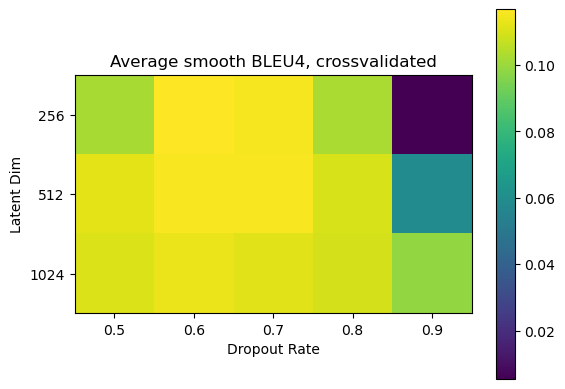

In [9]:
#Izvrsava se grid search nad hiperparametrima, i radi se unakrsna validacija za evaluaciju performansi
#Metrika nad kojom se vrsi selekcija je smooth BLEU4

metrics = cv_grid_search(df_train_val, dropout_rates, latent_dims, epochs = 200, learning_rate = learning_rate, folds = folds)
average_bleu4 = np.mean(metrics['smooth_bleu4'], axis = -1)

plt.title('Average smooth BLEU4, crossvalidated')
plt.xlabel('Dropout Rate')
plt.xticks(range(len(dropout_rates)), dropout_rates)
plt.ylabel('Latent Dim')
plt.yticks(range(len(latent_dims)),latent_dims)
plt.imshow(average_bleu4)
plt.colorbar()
plt.show()



In [ ]:
best_config_index = np.unravel_index(np.argmax(average_bleu4), average_bleu4.shape)
best_latent_dim = latent_dims[best_config_index[0]]
best_dropout_rate = dropout_rates[best_config_index[1]]
print("Best latent dimension: ", best_latent_dim)
print("Best dropout rate: ", best_dropout_rate)

In [ ]:
learning_rate_multipliers = [0.03, 0.1, 0.3, 1, 3, 10, 30] #Treba probati i vece vrednosti, posto 3 ispada optimalno (ovo je neocekivano)
#learning_rate_multipliers = [100]
best_epoch_array = []
bleu4_array = []
for i in range(len(learning_rate_multipliers)):
    df_np = df_train_val.to_numpy()
    np.random.shuffle(df_np)
    total_size = df_np.shape[0]
    fold_size = total_size/folds
    df_folds = [df_np[int(i*fold_size):int((i+1)*fold_size),] for i in range(folds)]
    best_epochs, _, _, smooth_bleu4s, _, _, _ = cv_evaluate(df_train_val, df_folds, folds = folds, epochs = 200, learning_rate = learning_rate, embedding_learning_rate = learning_rate_multipliers[i]*learning_rate, latent_dim = best_latent_dim, dropout_rate = best_dropout_rate)
    best_epoch_array.append(best_epochs)
    bleu4_array.append(smooth_bleu4s)

bleu4_array = np.array(bleu4_array)
best_epoch_array = np.array(best_epoch_array)
best_multiplier_index = np.argmax(np.mean(bleu4_array, -1))
bleu4_avg = np.mean(bleu4_array[best_multiplier_index])
print("Average BLEU4(smooth) on validation: ", bleu4_avg)
best_multiplier = learning_rate_multipliers[best_multiplier_index]
print("Best Multiplier for Embedding Learning Rates:", best_multiplier)
best_multiplier_epochs = best_epoch_array[best_multiplier_index]
print('Epochs to convergence on all folds: ', best_multiplier_epochs) #Gledamo koliko je epoha bilo potrebno do konvergencije
epoch_avg = np.mean(best_multiplier_epochs)#Prosek koristimo za broj epoha treniranja modela na trening i validacionom skupu

Current Latent Dim: 256
Current Dropout Rate:  0.6
Current Fold: 1/5
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  0.03
Embeddings loaded.
Epoch 1/200
48/48 [==============================] - 25s 211ms/step - loss: 0.9285 - acc: 0.1259 - val_loss: 0.7593 - val_acc: 0.2090
Epoch 2/200
48/48 [==============================] - 2s 48ms/step - loss: 0.7773 - acc: 0.2048 - val_loss: 0.7060 - val_acc: 0.2587
Epoch 3/200
48/48 [==============================] - 2s 48ms/step - loss: 0.7396 - acc: 0.2317 - val_loss: 0.6705 - val_acc: 0.2784
Epoch 4/200
48/48 [==============================] - 2s 48ms/step - loss: 0.7081 - acc: 0.2510 - val_loss: 0.6410 - val_acc: 0.3000
Epoch 5/200
48/48 [==============================] - 2s 48ms/step - loss: 0.6816 - acc: 0.2701 - val_loss: 0.6188 - val_acc: 0.3169
Epoch 6/200
48/48 [==============================] - 2s 48ms/step - loss: 0.6574 - acc: 0.2848 - val_loss: 0.6030 - val_acc: 0.3235
Epoch 7/200
48/48 [============================

48/48 [==============================] - 2s 48ms/step - loss: 0.6344 - acc: 0.2958 - val_loss: 0.6244 - val_acc: 0.3077
Epoch 8/200
48/48 [==============================] - 2s 48ms/step - loss: 0.6191 - acc: 0.3041 - val_loss: 0.6034 - val_acc: 0.3178
Epoch 9/200
48/48 [==============================] - 2s 48ms/step - loss: 0.6055 - acc: 0.3109 - val_loss: 0.6037 - val_acc: 0.3179
Epoch 10/200
48/48 [==============================] - 2s 48ms/step - loss: 0.5958 - acc: 0.3152 - val_loss: 0.5812 - val_acc: 0.3301
Epoch 11/200
48/48 [==============================] - 2s 48ms/step - loss: 0.5854 - acc: 0.3213 - val_loss: 0.5765 - val_acc: 0.3331
Epoch 12/200
48/48 [==============================] - 2s 48ms/step - loss: 0.5765 - acc: 0.3252 - val_loss: 0.5665 - val_acc: 0.3375
Epoch 13/200
48/48 [==============================] - 2s 48ms/step - loss: 0.5705 - acc: 0.3269 - val_loss: 0.5611 - val_acc: 0.3403
Epoch 14/200
48/48 [==============================] - 2s 49ms/step - loss: 0.5631 - 

Epoch 69/200
48/48 [==============================] - 2s 48ms/step - loss: 0.4142 - acc: 0.4423 - val_loss: 0.4555 - val_acc: 0.4397
Epoch 70/200
48/48 [==============================] - 2s 48ms/step - loss: 0.4123 - acc: 0.4453 - val_loss: 0.4550 - val_acc: 0.4418
Epoch 71/200
48/48 [==============================] - 2s 48ms/step - loss: 0.4106 - acc: 0.4474 - val_loss: 0.4558 - val_acc: 0.4413
Epoch 72/200
48/48 [==============================] - 2s 48ms/step - loss: 0.4090 - acc: 0.4464 - val_loss: 0.4534 - val_acc: 0.4452
Epoch 73/200
48/48 [==============================] - 2s 49ms/step - loss: 0.4082 - acc: 0.4500 - val_loss: 0.4549 - val_acc: 0.4414
Epoch 74/200
48/48 [==============================] - 2s 49ms/step - loss: 0.4064 - acc: 0.4502 - val_loss: 0.4544 - val_acc: 0.4447
Epoch 75/200
48/48 [==============================] - 2s 49ms/step - loss: 0.4051 - acc: 0.4515 - val_loss: 0.4514 - val_acc: 0.4454
Epoch 76/200
48/48 [==============================] - 2s 48ms/step - 

Epoch 86/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3936 - acc: 0.4618 - val_loss: 0.4319 - val_acc: 0.4561
Epoch 87/200
48/48 [==============================] - 2s 47ms/step - loss: 0.3919 - acc: 0.4642 - val_loss: 0.4351 - val_acc: 0.4526
Epoch 88/200
48/48 [==============================] - 2s 47ms/step - loss: 0.3900 - acc: 0.4642 - val_loss: 0.4345 - val_acc: 0.4550
Epoch 89/200
48/48 [==============================] - 2s 47ms/step - loss: 0.3895 - acc: 0.4651 - val_loss: 0.4341 - val_acc: 0.4561
Epoch 90/200
48/48 [==============================] - 2s 47ms/step - loss: 0.3884 - acc: 0.4673 - val_loss: 0.4330 - val_acc: 0.4551
Epoch 91/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3874 - acc: 0.4688 - val_loss: 0.4307 - val_acc: 0.4567
Epoch 92/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3850 - acc: 0.4694 - val_loss: 0.4305 - val_acc: 0.4567
Epoch 93/200
48/48 [==============================] - 2s 47ms/step - 

Epoch 95/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3810 - acc: 0.4714 - val_loss: 0.4466 - val_acc: 0.4537
Epoch 96/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3800 - acc: 0.4754 - val_loss: 0.4425 - val_acc: 0.4568
Epoch 97/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3774 - acc: 0.4761 - val_loss: 0.4416 - val_acc: 0.4556
Epoch 98/200
48/48 [==============================] - 2s 50ms/step - loss: 0.3772 - acc: 0.4759 - val_loss: 0.4411 - val_acc: 0.4563
Epoch 99/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3769 - acc: 0.4752 - val_loss: 0.4423 - val_acc: 0.4573
Epoch 100/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3750 - acc: 0.4775 - val_loss: 0.4401 - val_acc: 0.4570
Epoch 101/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3737 - acc: 0.4783 - val_loss: 0.4414 - val_acc: 0.4575
Epoch 102/200
48/48 [==============================] - 2s 48ms/step

Epoch 100: early stopping
Current Latent Dim: 256
Current Dropout Rate:  0.6
Current Fold: 1/5
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  0.1
Embeddings loaded.
Epoch 1/200
48/48 [==============================] - 25s 214ms/step - loss: 0.9322 - acc: 0.1342 - val_loss: 0.7565 - val_acc: 0.2045
Epoch 2/200
48/48 [==============================] - 2s 48ms/step - loss: 0.7764 - acc: 0.2068 - val_loss: 0.7063 - val_acc: 0.2445
Epoch 3/200
48/48 [==============================] - 2s 48ms/step - loss: 0.7367 - acc: 0.2348 - val_loss: 0.6763 - val_acc: 0.2673
Epoch 4/200
48/48 [==============================] - 2s 48ms/step - loss: 0.7068 - acc: 0.2555 - val_loss: 0.6486 - val_acc: 0.2873
Epoch 5/200
48/48 [==============================] - 2s 48ms/step - loss: 0.6807 - acc: 0.2704 - val_loss: 0.6226 - val_acc: 0.3032
Epoch 6/200
48/48 [==============================] - 2s 48ms/step - loss: 0.6586 - acc: 0.2850 - val_loss: 0.6094 - val_acc: 0.3140
Epoch 7/200
48/48 [===

48/48 [==============================] - 2s 48ms/step - loss: 0.5461 - acc: 0.3467 - val_loss: 0.5148 - val_acc: 0.3700
Epoch 18/200
48/48 [==============================] - 2s 48ms/step - loss: 0.5407 - acc: 0.3506 - val_loss: 0.5108 - val_acc: 0.3733
Epoch 19/200
48/48 [==============================] - 2s 48ms/step - loss: 0.5366 - acc: 0.3522 - val_loss: 0.5091 - val_acc: 0.3735
Epoch 20/200
48/48 [==============================] - 2s 48ms/step - loss: 0.5319 - acc: 0.3555 - val_loss: 0.5042 - val_acc: 0.3775
Epoch 21/200
48/48 [==============================] - 2s 48ms/step - loss: 0.5273 - acc: 0.3591 - val_loss: 0.5003 - val_acc: 0.3815
Epoch 22/200
48/48 [==============================] - 2s 48ms/step - loss: 0.5232 - acc: 0.3615 - val_loss: 0.4990 - val_acc: 0.3808
Epoch 23/200
48/48 [==============================] - 2s 48ms/step - loss: 0.5199 - acc: 0.3630 - val_loss: 0.4961 - val_acc: 0.3832
Epoch 24/200
48/48 [==============================] - 2s 48ms/step - loss: 0.5154 

Epoch 79/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3998 - acc: 0.4585 - val_loss: 0.4340 - val_acc: 0.4504
Epoch 80/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3981 - acc: 0.4560 - val_loss: 0.4336 - val_acc: 0.4525
Epoch 81/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3967 - acc: 0.4604 - val_loss: 0.4329 - val_acc: 0.4543
Epoch 82/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3951 - acc: 0.4606 - val_loss: 0.4331 - val_acc: 0.4525
Epoch 83/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3946 - acc: 0.4627 - val_loss: 0.4324 - val_acc: 0.4549
Epoch 84/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3929 - acc: 0.4628 - val_loss: 0.4329 - val_acc: 0.4533
Epoch 85/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3903 - acc: 0.4668 - val_loss: 0.4317 - val_acc: 0.4556
Epoch 86/200
48/48 [==============================] - 2s 48ms/step - 

Epoch 92/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3802 - acc: 0.4739 - val_loss: 0.4396 - val_acc: 0.4551
Epoch 93/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3802 - acc: 0.4728 - val_loss: 0.4392 - val_acc: 0.4558
Epoch 94/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3781 - acc: 0.4736 - val_loss: 0.4400 - val_acc: 0.4554
Epoch 95/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3772 - acc: 0.4762 - val_loss: 0.4397 - val_acc: 0.4559
Epoch 96/200
48/48 [==============================] - 2s 50ms/step - loss: 0.3758 - acc: 0.4758 - val_loss: 0.4412 - val_acc: 0.4562
Epoch 97/200
48/48 [==============================] - 2s 50ms/step - loss: 0.3748 - acc: 0.4787 - val_loss: 0.4391 - val_acc: 0.4568
Epoch 98/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3735 - acc: 0.4800 - val_loss: 0.4392 - val_acc: 0.4571
Epoch 99/200
48/48 [==============================] - 2s 49ms/step - 

Epoch 97/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3767 - acc: 0.4787 - val_loss: 0.4257 - val_acc: 0.4605
Epoch 98/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3765 - acc: 0.4780 - val_loss: 0.4249 - val_acc: 0.4616
Epoch 99/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3744 - acc: 0.4809 - val_loss: 0.4257 - val_acc: 0.4612
Epoch 100/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3733 - acc: 0.4797 - val_loss: 0.4259 - val_acc: 0.4600
Epoch 101/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3716 - acc: 0.4816 - val_loss: 0.4263 - val_acc: 0.4611
Epoch 102/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3715 - acc: 0.4830 - val_loss: 0.4257 - val_acc: 0.4621
Epoch 103/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3699 - acc: 0.4836 - val_loss: 0.4245 - val_acc: 0.4636
Epoch 104/200
48/48 [==============================] - 2s 48ms/st

48/48 [==============================] - 2s 48ms/step - loss: 0.4853 - acc: 0.3856 - val_loss: 0.4811 - val_acc: 0.4099
Epoch 34/200
48/48 [==============================] - 2s 47ms/step - loss: 0.4820 - acc: 0.3890 - val_loss: 0.4832 - val_acc: 0.4107
Epoch 35/200
48/48 [==============================] - 2s 48ms/step - loss: 0.4806 - acc: 0.3882 - val_loss: 0.4764 - val_acc: 0.4117
Epoch 36/200
48/48 [==============================] - 2s 48ms/step - loss: 0.4778 - acc: 0.3907 - val_loss: 0.4757 - val_acc: 0.4130
Epoch 37/200
48/48 [==============================] - 2s 47ms/step - loss: 0.4751 - acc: 0.3943 - val_loss: 0.4762 - val_acc: 0.4155
Epoch 38/200
48/48 [==============================] - 2s 48ms/step - loss: 0.4724 - acc: 0.3967 - val_loss: 0.4734 - val_acc: 0.4170
Epoch 39/200
48/48 [==============================] - 2s 48ms/step - loss: 0.4705 - acc: 0.3968 - val_loss: 0.4726 - val_acc: 0.4205
Epoch 40/200
48/48 [==============================] - 2s 49ms/step - loss: 0.4674 

Epoch 95/200
48/48 [==============================] - 2s 47ms/step - loss: 0.3773 - acc: 0.4765 - val_loss: 0.4417 - val_acc: 0.4584
Epoch 96/200
48/48 [==============================] - 2s 47ms/step - loss: 0.3758 - acc: 0.4785 - val_loss: 0.4400 - val_acc: 0.4600
Epoch 97/200
48/48 [==============================] - 2s 47ms/step - loss: 0.3739 - acc: 0.4810 - val_loss: 0.4402 - val_acc: 0.4615
Epoch 98/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3733 - acc: 0.4810 - val_loss: 0.4408 - val_acc: 0.4593
Epoch 99/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3722 - acc: 0.4807 - val_loss: 0.4393 - val_acc: 0.4583
Epoch 100/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3704 - acc: 0.4835 - val_loss: 0.4390 - val_acc: 0.4600
Epoch 101/200
48/48 [==============================] - 2s 47ms/step - loss: 0.3691 - acc: 0.4869 - val_loss: 0.4425 - val_acc: 0.4591
Epoch 102/200
48/48 [==============================] - 2s 47ms/step

48/48 [==============================] - 2s 49ms/step - loss: 0.4967 - acc: 0.3817 - val_loss: 0.4757 - val_acc: 0.3989
Epoch 30/200
48/48 [==============================] - 2s 49ms/step - loss: 0.4926 - acc: 0.3845 - val_loss: 0.4732 - val_acc: 0.4035
Epoch 31/200
48/48 [==============================] - 2s 49ms/step - loss: 0.4910 - acc: 0.3853 - val_loss: 0.4718 - val_acc: 0.4024
Epoch 32/200
48/48 [==============================] - 2s 49ms/step - loss: 0.4870 - acc: 0.3885 - val_loss: 0.4693 - val_acc: 0.4062
Epoch 33/200
48/48 [==============================] - 2s 49ms/step - loss: 0.4845 - acc: 0.3898 - val_loss: 0.4680 - val_acc: 0.4076
Epoch 34/200
48/48 [==============================] - 2s 48ms/step - loss: 0.4814 - acc: 0.3946 - val_loss: 0.4680 - val_acc: 0.4108
Epoch 35/200
48/48 [==============================] - 2s 49ms/step - loss: 0.4796 - acc: 0.3933 - val_loss: 0.4657 - val_acc: 0.4084
Epoch 36/200
48/48 [==============================] - 2s 49ms/step - loss: 0.4757 

Epoch 91/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3787 - acc: 0.4798 - val_loss: 0.4257 - val_acc: 0.4620
Epoch 92/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3777 - acc: 0.4802 - val_loss: 0.4274 - val_acc: 0.4635
Epoch 93/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3773 - acc: 0.4796 - val_loss: 0.4270 - val_acc: 0.4644
Epoch 94/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3750 - acc: 0.4815 - val_loss: 0.4273 - val_acc: 0.4647
Epoch 95/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3736 - acc: 0.4813 - val_loss: 0.4281 - val_acc: 0.4644
Epoch 96/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3736 - acc: 0.4838 - val_loss: 0.4276 - val_acc: 0.4647
Epoch 97/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3704 - acc: 0.4866 - val_loss: 0.4274 - val_acc: 0.4647
Epoch 98/200
48/48 [==============================] - 2s 49ms/step - 

48/48 [==============================] - 2s 49ms/step - loss: 0.3551 - acc: 0.4995 - val_loss: 0.4234 - val_acc: 0.4735
Epoch 111/200
48/48 [==============================] - 2s 50ms/step - loss: 0.3537 - acc: 0.5003 - val_loss: 0.4223 - val_acc: 0.4742
Epoch 112/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3519 - acc: 0.4997 - val_loss: 0.4238 - val_acc: 0.4745
Epoch 113/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3505 - acc: 0.5027 - val_loss: 0.4230 - val_acc: 0.4725
Epoch 114/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3498 - acc: 0.5031 - val_loss: 0.4239 - val_acc: 0.4742
Epoch 115/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3490 - acc: 0.5054 - val_loss: 0.4228 - val_acc: 0.4746
Epoch 116/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3484 - acc: 0.5054 - val_loss: 0.4231 - val_acc: 0.4756
Epoch 117/200
48/48 [==============================] - 2s 49ms/step - loss: 

48/48 [==============================] - 2s 49ms/step - loss: 0.5068 - acc: 0.3723 - val_loss: 0.4893 - val_acc: 0.3987
Epoch 26/200
48/48 [==============================] - 2s 48ms/step - loss: 0.5039 - acc: 0.3749 - val_loss: 0.4905 - val_acc: 0.3979
Epoch 27/200
48/48 [==============================] - 2s 49ms/step - loss: 0.5003 - acc: 0.3768 - val_loss: 0.4853 - val_acc: 0.4007
Epoch 28/200
48/48 [==============================] - 2s 49ms/step - loss: 0.4965 - acc: 0.3804 - val_loss: 0.4832 - val_acc: 0.4029
Epoch 29/200
48/48 [==============================] - 2s 49ms/step - loss: 0.4941 - acc: 0.3814 - val_loss: 0.4823 - val_acc: 0.4045
Epoch 30/200
48/48 [==============================] - 2s 49ms/step - loss: 0.4904 - acc: 0.3842 - val_loss: 0.4802 - val_acc: 0.4065
Epoch 31/200
48/48 [==============================] - 2s 50ms/step - loss: 0.4881 - acc: 0.3853 - val_loss: 0.4773 - val_acc: 0.4086
Epoch 32/200
48/48 [==============================] - 2s 50ms/step - loss: 0.4852 

Epoch 87/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3822 - acc: 0.4741 - val_loss: 0.4332 - val_acc: 0.4601
Epoch 88/200
48/48 [==============================] - 2s 50ms/step - loss: 0.3796 - acc: 0.4778 - val_loss: 0.4340 - val_acc: 0.4599
Epoch 89/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3788 - acc: 0.4763 - val_loss: 0.4319 - val_acc: 0.4633
Epoch 90/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3777 - acc: 0.4775 - val_loss: 0.4315 - val_acc: 0.4618
Epoch 91/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3764 - acc: 0.4799 - val_loss: 0.4334 - val_acc: 0.4606
Epoch 92/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3750 - acc: 0.4791 - val_loss: 0.4311 - val_acc: 0.4616
Epoch 93/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3735 - acc: 0.4808 - val_loss: 0.4320 - val_acc: 0.4631
Epoch 94/200
48/48 [==============================] - 2s 49ms/step - 

48/48 [==============================] - 2s 48ms/step - loss: 0.3627 - acc: 0.4928 - val_loss: 0.4337 - val_acc: 0.4646
Epoch 103/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3623 - acc: 0.4925 - val_loss: 0.4319 - val_acc: 0.4653
Epoch 104/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3606 - acc: 0.4954 - val_loss: 0.4329 - val_acc: 0.4635
Epoch 105/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3599 - acc: 0.4965 - val_loss: 0.4348 - val_acc: 0.4650
Epoch 106/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3596 - acc: 0.4939 - val_loss: 0.4314 - val_acc: 0.4661
Epoch 107/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3572 - acc: 0.4957 - val_loss: 0.4328 - val_acc: 0.4659
Epoch 108/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3555 - acc: 0.4983 - val_loss: 0.4317 - val_acc: 0.4661
Epoch 109/200
48/48 [==============================] - 2s 48ms/step - loss: 

48/48 [==============================] - 2s 49ms/step - loss: 0.5592 - acc: 0.3418 - val_loss: 0.5326 - val_acc: 0.3632
Epoch 14/200
48/48 [==============================] - 2s 49ms/step - loss: 0.5519 - acc: 0.3471 - val_loss: 0.5270 - val_acc: 0.3669
Epoch 15/200
48/48 [==============================] - 2s 49ms/step - loss: 0.5461 - acc: 0.3484 - val_loss: 0.5210 - val_acc: 0.3712
Epoch 16/200
48/48 [==============================] - 2s 49ms/step - loss: 0.5403 - acc: 0.3519 - val_loss: 0.5169 - val_acc: 0.3748
Epoch 17/200
48/48 [==============================] - 2s 49ms/step - loss: 0.5357 - acc: 0.3545 - val_loss: 0.5120 - val_acc: 0.3773
Epoch 18/200
48/48 [==============================] - 2s 49ms/step - loss: 0.5302 - acc: 0.3573 - val_loss: 0.5084 - val_acc: 0.3774
Epoch 19/200
48/48 [==============================] - 2s 49ms/step - loss: 0.5249 - acc: 0.3599 - val_loss: 0.5063 - val_acc: 0.3807
Epoch 20/200
48/48 [==============================] - 2s 49ms/step - loss: 0.5213 

Epoch 75/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3888 - acc: 0.4702 - val_loss: 0.4317 - val_acc: 0.4629
Epoch 76/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3890 - acc: 0.4709 - val_loss: 0.4320 - val_acc: 0.4639
Epoch 77/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3870 - acc: 0.4717 - val_loss: 0.4318 - val_acc: 0.4642
Epoch 78/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3861 - acc: 0.4735 - val_loss: 0.4317 - val_acc: 0.4659
Epoch 79/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3834 - acc: 0.4773 - val_loss: 0.4305 - val_acc: 0.4643
Epoch 80/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3814 - acc: 0.4777 - val_loss: 0.4307 - val_acc: 0.4676
Epoch 81/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3801 - acc: 0.4795 - val_loss: 0.4306 - val_acc: 0.4680
Epoch 82/200
48/48 [==============================] - 2s 48ms/step - 

Epoch 97/200
48/48 [==============================] - 2s 50ms/step - loss: 0.3552 - acc: 0.5016 - val_loss: 0.4376 - val_acc: 0.4648
Epoch 98/200
48/48 [==============================] - 2s 50ms/step - loss: 0.3533 - acc: 0.5029 - val_loss: 0.4386 - val_acc: 0.4638
Epoch 99/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3516 - acc: 0.5041 - val_loss: 0.4372 - val_acc: 0.4658
Epoch 100/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3503 - acc: 0.5057 - val_loss: 0.4362 - val_acc: 0.4665
Epoch 101/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3503 - acc: 0.5063 - val_loss: 0.4379 - val_acc: 0.4653
Epoch 102/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3485 - acc: 0.5070 - val_loss: 0.4361 - val_acc: 0.4680
Epoch 103/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3473 - acc: 0.5083 - val_loss: 0.4375 - val_acc: 0.4671
Epoch 104/200
48/48 [==============================] - 2s 48ms/st

48/48 [==============================] - 2s 49ms/step - loss: 0.4773 - acc: 0.3965 - val_loss: 0.4548 - val_acc: 0.4202
Epoch 34/200
48/48 [==============================] - 2s 49ms/step - loss: 0.4746 - acc: 0.3989 - val_loss: 0.4533 - val_acc: 0.4239
Epoch 35/200
48/48 [==============================] - 2s 49ms/step - loss: 0.4719 - acc: 0.4008 - val_loss: 0.4515 - val_acc: 0.4253
Epoch 36/200
48/48 [==============================] - 2s 49ms/step - loss: 0.4690 - acc: 0.4024 - val_loss: 0.4508 - val_acc: 0.4264
Epoch 37/200
48/48 [==============================] - 2s 49ms/step - loss: 0.4661 - acc: 0.4057 - val_loss: 0.4482 - val_acc: 0.4288
Epoch 38/200
48/48 [==============================] - 2s 49ms/step - loss: 0.4639 - acc: 0.4061 - val_loss: 0.4463 - val_acc: 0.4306
Epoch 39/200
48/48 [==============================] - 2s 48ms/step - loss: 0.4601 - acc: 0.4110 - val_loss: 0.4465 - val_acc: 0.4327
Epoch 40/200
48/48 [==============================] - 2s 49ms/step - loss: 0.4592 

48/48 [==============================] - 2s 49ms/step - loss: 0.3627 - acc: 0.4958 - val_loss: 0.4142 - val_acc: 0.4783
Epoch 94: early stopping
Current Latent Dim: 256
Current Dropout Rate:  0.6
Current Fold: 5/5
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  1.0
Embeddings loaded.
Epoch 1/200
48/48 [==============================] - 25s 221ms/step - loss: 0.9342 - acc: 0.1278 - val_loss: 0.7553 - val_acc: 0.2032
Epoch 2/200
48/48 [==============================] - 2s 49ms/step - loss: 0.7714 - acc: 0.2095 - val_loss: 0.7068 - val_acc: 0.2520
Epoch 3/200
48/48 [==============================] - 2s 49ms/step - loss: 0.7285 - acc: 0.2377 - val_loss: 0.6648 - val_acc: 0.2827
Epoch 4/200
48/48 [==============================] - 2s 50ms/step - loss: 0.6927 - acc: 0.2659 - val_loss: 0.6329 - val_acc: 0.3050
Epoch 5/200
48/48 [==============================] - 2s 50ms/step - loss: 0.6636 - acc: 0.2845 - val_loss: 0.6124 - val_acc: 0.3172
Epoch 6/200
48/48 [================

48/48 [==============================] - 2s 48ms/step - loss: 0.5784 - acc: 0.3339 - val_loss: 0.5412 - val_acc: 0.3572
Epoch 11/200
48/48 [==============================] - 2s 48ms/step - loss: 0.5691 - acc: 0.3382 - val_loss: 0.5383 - val_acc: 0.3617
Epoch 12/200
48/48 [==============================] - 2s 48ms/step - loss: 0.5607 - acc: 0.3436 - val_loss: 0.5291 - val_acc: 0.3682
Epoch 13/200
48/48 [==============================] - 2s 48ms/step - loss: 0.5528 - acc: 0.3467 - val_loss: 0.5244 - val_acc: 0.3706
Epoch 14/200
48/48 [==============================] - 2s 48ms/step - loss: 0.5465 - acc: 0.3518 - val_loss: 0.5202 - val_acc: 0.3730
Epoch 15/200
48/48 [==============================] - 2s 48ms/step - loss: 0.5399 - acc: 0.3537 - val_loss: 0.5136 - val_acc: 0.3776
Epoch 16/200
48/48 [==============================] - 2s 48ms/step - loss: 0.5341 - acc: 0.3587 - val_loss: 0.5128 - val_acc: 0.3804
Epoch 17/200
48/48 [==============================] - 2s 48ms/step - loss: 0.5286 

Epoch 72/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3776 - acc: 0.4866 - val_loss: 0.4268 - val_acc: 0.4668
Epoch 73/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3740 - acc: 0.4879 - val_loss: 0.4256 - val_acc: 0.4682
Epoch 74/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3736 - acc: 0.4885 - val_loss: 0.4255 - val_acc: 0.4679
Epoch 75/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3723 - acc: 0.4897 - val_loss: 0.4260 - val_acc: 0.4703
Epoch 76/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3696 - acc: 0.4922 - val_loss: 0.4268 - val_acc: 0.4704
Epoch 77/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3689 - acc: 0.4916 - val_loss: 0.4260 - val_acc: 0.4695
Epoch 78/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3665 - acc: 0.4939 - val_loss: 0.4242 - val_acc: 0.4700
Epoch 79/200
48/48 [==============================] - 2s 48ms/step - 

Epoch 90/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3477 - acc: 0.5117 - val_loss: 0.4206 - val_acc: 0.4836
Epoch 91/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3473 - acc: 0.5124 - val_loss: 0.4198 - val_acc: 0.4825
Epoch 92/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3457 - acc: 0.5137 - val_loss: 0.4210 - val_acc: 0.4828
Epoch 93/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3449 - acc: 0.5120 - val_loss: 0.4203 - val_acc: 0.4820
Epoch 94/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3434 - acc: 0.5165 - val_loss: 0.4197 - val_acc: 0.4837
Epoch 95/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3415 - acc: 0.5187 - val_loss: 0.4213 - val_acc: 0.4822
Epoch 96/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3413 - acc: 0.5179 - val_loss: 0.4208 - val_acc: 0.4846
Epoch 97/200
48/48 [==============================] - 2s 49ms/step - 

Epoch 99/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3311 - acc: 0.5291 - val_loss: 0.4368 - val_acc: 0.4743
Epoch 100/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3295 - acc: 0.5291 - val_loss: 0.4387 - val_acc: 0.4744
Epoch 101/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3285 - acc: 0.5313 - val_loss: 0.4361 - val_acc: 0.4730
Epoch 102/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3279 - acc: 0.5309 - val_loss: 0.4382 - val_acc: 0.4731
Epoch 103/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3249 - acc: 0.5368 - val_loss: 0.4373 - val_acc: 0.4738
Epoch 104/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3243 - acc: 0.5365 - val_loss: 0.4375 - val_acc: 0.4752
Epoch 105/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3229 - acc: 0.5369 - val_loss: 0.4369 - val_acc: 0.4764
Epoch 106/200
48/48 [==============================] - 2s 48ms/

48/48 [==============================] - 2s 49ms/step - loss: 0.6179 - acc: 0.3149 - val_loss: 0.5717 - val_acc: 0.3381
Epoch 8/200
48/48 [==============================] - 2s 49ms/step - loss: 0.6032 - acc: 0.3211 - val_loss: 0.5560 - val_acc: 0.3459
Epoch 9/200
48/48 [==============================] - 2s 49ms/step - loss: 0.5901 - acc: 0.3274 - val_loss: 0.5501 - val_acc: 0.3504
Epoch 10/200
48/48 [==============================] - 2s 49ms/step - loss: 0.5790 - acc: 0.3337 - val_loss: 0.5450 - val_acc: 0.3542
Epoch 11/200
48/48 [==============================] - 2s 49ms/step - loss: 0.5697 - acc: 0.3390 - val_loss: 0.5356 - val_acc: 0.3586
Epoch 12/200
48/48 [==============================] - 2s 49ms/step - loss: 0.5615 - acc: 0.3405 - val_loss: 0.5283 - val_acc: 0.3641
Epoch 13/200
48/48 [==============================] - 2s 49ms/step - loss: 0.5533 - acc: 0.3465 - val_loss: 0.5233 - val_acc: 0.3693
Epoch 14/200
48/48 [==============================] - 2s 49ms/step - loss: 0.5468 - 

Epoch 69/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3824 - acc: 0.4812 - val_loss: 0.4203 - val_acc: 0.4707
Epoch 70/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3819 - acc: 0.4831 - val_loss: 0.4220 - val_acc: 0.4722
Epoch 71/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3791 - acc: 0.4846 - val_loss: 0.4196 - val_acc: 0.4719
Epoch 72/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3773 - acc: 0.4838 - val_loss: 0.4199 - val_acc: 0.4742
Epoch 73/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3755 - acc: 0.4873 - val_loss: 0.4213 - val_acc: 0.4741
Epoch 74/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3741 - acc: 0.4874 - val_loss: 0.4198 - val_acc: 0.4745
Epoch 75/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3713 - acc: 0.4887 - val_loss: 0.4195 - val_acc: 0.4761
Epoch 76/200
48/48 [==============================] - 2s 49ms/step - 

Epoch 91/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3190 - acc: 0.5437 - val_loss: 0.4335 - val_acc: 0.4814
Epoch 92/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3178 - acc: 0.5448 - val_loss: 0.4331 - val_acc: 0.4815
Epoch 93/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3158 - acc: 0.5476 - val_loss: 0.4337 - val_acc: 0.4817
Epoch 94/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3146 - acc: 0.5485 - val_loss: 0.4351 - val_acc: 0.4810
Epoch 94: early stopping
Current Latent Dim: 256
Current Dropout Rate:  0.6
Current Fold: 2/5
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  10.0
Embeddings loaded.
Epoch 1/200
48/48 [==============================] - 25s 216ms/step - loss: 0.9131 - acc: 0.1515 - val_loss: 0.7570 - val_acc: 0.2137
Epoch 2/200
48/48 [==============================] - 2s 49ms/step - loss: 0.7475 - acc: 0.2277 - val_loss: 0.6916 - val_acc: 0.2728
Epoch 3/200
48/48 

48/48 [==============================] - 2s 50ms/step - loss: 0.4467 - acc: 0.4302 - val_loss: 0.4479 - val_acc: 0.4419
Epoch 33/200
48/48 [==============================] - 2s 50ms/step - loss: 0.4445 - acc: 0.4310 - val_loss: 0.4490 - val_acc: 0.4423
Epoch 34/200
48/48 [==============================] - 2s 49ms/step - loss: 0.4398 - acc: 0.4347 - val_loss: 0.4453 - val_acc: 0.4452
Epoch 35/200
48/48 [==============================] - 2s 48ms/step - loss: 0.4367 - acc: 0.4371 - val_loss: 0.4465 - val_acc: 0.4471
Epoch 36/200
48/48 [==============================] - 2s 49ms/step - loss: 0.4331 - acc: 0.4394 - val_loss: 0.4439 - val_acc: 0.4475
Epoch 37/200
48/48 [==============================] - 2s 49ms/step - loss: 0.4305 - acc: 0.4428 - val_loss: 0.4421 - val_acc: 0.4506
Epoch 38/200
48/48 [==============================] - 2s 48ms/step - loss: 0.4276 - acc: 0.4441 - val_loss: 0.4431 - val_acc: 0.4502
Epoch 39/200
48/48 [==============================] - 2s 49ms/step - loss: 0.4249 

Epoch 70/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3583 - acc: 0.5066 - val_loss: 0.4206 - val_acc: 0.4787
Epoch 71/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3558 - acc: 0.5108 - val_loss: 0.4183 - val_acc: 0.4773
Epoch 72/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3542 - acc: 0.5110 - val_loss: 0.4183 - val_acc: 0.4801
Epoch 73/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3515 - acc: 0.5163 - val_loss: 0.4199 - val_acc: 0.4804
Epoch 74/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3502 - acc: 0.5162 - val_loss: 0.4205 - val_acc: 0.4813
Epoch 75/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3488 - acc: 0.5170 - val_loss: 0.4192 - val_acc: 0.4824
Epoch 76/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3472 - acc: 0.5192 - val_loss: 0.4190 - val_acc: 0.4837
Epoch 77/200
48/48 [==============================] - 2s 48ms/step - 

48/48 [==============================] - 2s 49ms/step - loss: 0.6558 - acc: 0.3001 - val_loss: 0.6018 - val_acc: 0.3236
Epoch 5/200
48/48 [==============================] - 2s 49ms/step - loss: 0.6294 - acc: 0.3134 - val_loss: 0.5833 - val_acc: 0.3348
Epoch 6/200
48/48 [==============================] - 2s 48ms/step - loss: 0.6076 - acc: 0.3240 - val_loss: 0.5663 - val_acc: 0.3438
Epoch 7/200
48/48 [==============================] - 2s 49ms/step - loss: 0.5889 - acc: 0.3346 - val_loss: 0.5511 - val_acc: 0.3555
Epoch 8/200
48/48 [==============================] - 2s 49ms/step - loss: 0.5732 - acc: 0.3408 - val_loss: 0.5426 - val_acc: 0.3603
Epoch 9/200
48/48 [==============================] - 2s 48ms/step - loss: 0.5599 - acc: 0.3488 - val_loss: 0.5333 - val_acc: 0.3663
Epoch 10/200
48/48 [==============================] - 2s 48ms/step - loss: 0.5487 - acc: 0.3552 - val_loss: 0.5222 - val_acc: 0.3727
Epoch 11/200
48/48 [==============================] - 2s 48ms/step - loss: 0.5403 - acc

Epoch 66/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3445 - acc: 0.5233 - val_loss: 0.4292 - val_acc: 0.4802
Epoch 67/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3434 - acc: 0.5234 - val_loss: 0.4297 - val_acc: 0.4792
Epoch 68/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3412 - acc: 0.5265 - val_loss: 0.4298 - val_acc: 0.4793
Epoch 69/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3401 - acc: 0.5286 - val_loss: 0.4299 - val_acc: 0.4783
Epoch 70/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3396 - acc: 0.5270 - val_loss: 0.4292 - val_acc: 0.4807
Epoch 71/200
48/48 [==============================] - 2s 49ms/step - loss: 0.3369 - acc: 0.5316 - val_loss: 0.4277 - val_acc: 0.4818
Epoch 72/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3351 - acc: 0.5334 - val_loss: 0.4292 - val_acc: 0.4813
Epoch 73/200
48/48 [==============================] - 2s 48ms/step - 

48/48 [==============================] - 2s 49ms/step - loss: 0.4817 - acc: 0.4049 - val_loss: 0.4815 - val_acc: 0.4167
Epoch 20/200
48/48 [==============================] - 2s 49ms/step - loss: 0.4771 - acc: 0.4071 - val_loss: 0.4797 - val_acc: 0.4199
Epoch 21/200
48/48 [==============================] - 2s 49ms/step - loss: 0.4716 - acc: 0.4125 - val_loss: 0.4785 - val_acc: 0.4220
Epoch 22/200
48/48 [==============================] - 2s 49ms/step - loss: 0.4664 - acc: 0.4168 - val_loss: 0.4729 - val_acc: 0.4249
Epoch 23/200
48/48 [==============================] - 2s 49ms/step - loss: 0.4623 - acc: 0.4211 - val_loss: 0.4722 - val_acc: 0.4265
Epoch 24/200
48/48 [==============================] - 2s 49ms/step - loss: 0.4584 - acc: 0.4241 - val_loss: 0.4694 - val_acc: 0.4280
Epoch 25/200
48/48 [==============================] - 2s 49ms/step - loss: 0.4539 - acc: 0.4263 - val_loss: 0.4662 - val_acc: 0.4303
Epoch 26/200
48/48 [==============================] - 2s 48ms/step - loss: 0.4495 

Epoch 81/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3170 - acc: 0.5529 - val_loss: 0.4340 - val_acc: 0.4832
Epoch 82/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3169 - acc: 0.5493 - val_loss: 0.4333 - val_acc: 0.4850
Epoch 83/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3139 - acc: 0.5561 - val_loss: 0.4332 - val_acc: 0.4834
Epoch 84/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3112 - acc: 0.5558 - val_loss: 0.4340 - val_acc: 0.4841
Epoch 85/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3111 - acc: 0.5580 - val_loss: 0.4334 - val_acc: 0.4884
Epoch 86/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3092 - acc: 0.5600 - val_loss: 0.4331 - val_acc: 0.4876
Epoch 87/200
48/48 [==============================] - 2s 48ms/step - loss: 0.3075 - acc: 0.5604 - val_loss: 0.4343 - val_acc: 0.4883
Epoch 88/200
48/48 [==============================] - 2s 48ms/step - 

48/48 [==============================] - 2s 49ms/step - loss: 0.4334 - acc: 0.4432 - val_loss: 0.4593 - val_acc: 0.4430
Epoch 31/200
48/48 [==============================] - 2s 48ms/step - loss: 0.4294 - acc: 0.4452 - val_loss: 0.4578 - val_acc: 0.4429
Epoch 32/200
48/48 [==============================] - 2s 48ms/step - loss: 0.4256 - acc: 0.4498 - val_loss: 0.4579 - val_acc: 0.4450
Epoch 33/200
48/48 [==============================] - 2s 48ms/step - loss: 0.4229 - acc: 0.4538 - val_loss: 0.4542 - val_acc: 0.4464
Epoch 34/200
48/48 [==============================] - 2s 48ms/step - loss: 0.4195 - acc: 0.4539 - val_loss: 0.4546 - val_acc: 0.4479
Epoch 35/200
48/48 [==============================] - 2s 48ms/step - loss: 0.4158 - acc: 0.4579 - val_loss: 0.4534 - val_acc: 0.4520
Epoch 36/200
48/48 [==============================] - 2s 48ms/step - loss: 0.4119 - acc: 0.4624 - val_loss: 0.4511 - val_acc: 0.4532
Epoch 37/200
48/48 [==============================] - 2s 48ms/step - loss: 0.4098 

In [ ]:
plt.title('Average smooth BLEU4 for different embedding learning rates')
plt.xlabel('Learning Rate Multiplier')
plt.yticks([])
plt.xticks(range(len(learning_rate_multipliers)), learning_rate_multipliers)
plt.imshow(np.mean(bleu4_array, axis = 1).reshape(1,-1))
plt.colorbar()
plt.show()

In [ ]:
df_train_val_np = df_train_val.to_numpy()
np.random.shuffle(df_train_val_np)
split_size = 300 #Mozda treba vise
train_data = df_train_val_np[:train_size + val_size - split_size,]
val_data = df_train_val_np[train_size + val_size - split_size:,]
input_texts, target_texts = clean_texts(train_data[:,1], train_data[:,0])
input_word_index, target_word_index, max_input_seq_len, max_target_seq_len = analyse_texts(input_texts, target_texts)
input_pad_len = 80
target_pad_len = 60
num_input_words = len(input_word_index) - 1
num_target_words = len(target_word_index) - 1
inverted_input_word_index = {value: key for key,value in input_word_index.items()}
inverted_target_word_index = {value: key for (key,value) in target_word_index.items()}
input_embedding_matrix, target_embedding_matrix = load_embedding_data_get_matrices(inverted_input_word_index, inverted_target_word_index)
encoder_input_data, decoder_input_data, decoder_output_data = create_model_data(input_texts, target_texts, input_word_index, target_word_index, input_pad_len, target_pad_len)

input_texts_val, target_texts_val = clean_texts(val_data[:,1], val_data[:,0])
encoder_input_data_val, decoder_input_data_val, decoder_output_data_val = create_model_data(input_texts_val, target_texts_val, input_word_index, target_word_index, input_pad_len, target_pad_len)

input_texts_test, target_texts_test = clean_texts_df(df_test)
encoder_input_data_test, decoder_input_data_test, decoder_output_data_test = create_model_data(input_texts_test, target_texts_test, input_word_index, target_word_index, input_pad_len, target_pad_len)

Epoch 1/200
58/58 [==============================] - 25s 175ms/step - loss: 0.8748 - acc: 0.1665 - val_loss: 0.7266 - val_acc: 0.2492
Epoch 2/200
58/58 [==============================] - 3s 52ms/step - loss: 0.7179 - acc: 0.2493 - val_loss: 0.6594 - val_acc: 0.3005
Epoch 3/200
58/58 [==============================] - 3s 46ms/step - loss: 0.6661 - acc: 0.2881 - val_loss: 0.6145 - val_acc: 0.3292
Epoch 4/200
58/58 [==============================] - 3s 46ms/step - loss: 0.6273 - acc: 0.3113 - val_loss: 0.5837 - val_acc: 0.3452
Epoch 5/200
58/58 [==============================] - 3s 46ms/step - loss: 0.5994 - acc: 0.3247 - val_loss: 0.5655 - val_acc: 0.3553
Epoch 6/200
58/58 [==============================] - 3s 46ms/step - loss: 0.5790 - acc: 0.3356 - val_loss: 0.5462 - val_acc: 0.3635
Epoch 7/200
58/58 [==============================] - 3s 50ms/step - loss: 0.5631 - acc: 0.3448 - val_loss: 0.5351 - val_acc: 0.3710
Epoch 8/200
58/58 [==============================] - 3s 49ms/step - loss: 

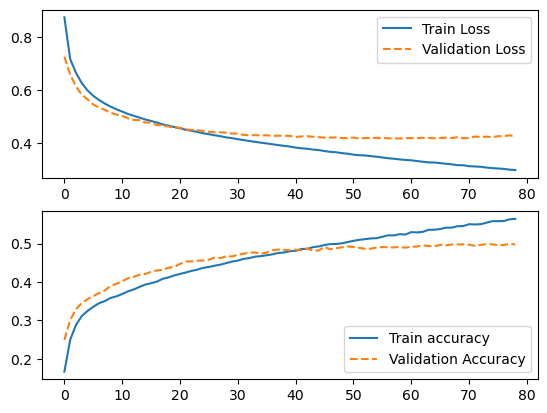

In [ ]:
model_for_evaluation = GRU_Translation_Model(num_input_words, num_target_words, input_embedding_matrix, target_embedding_matrix)

other_layers = model_for_evaluation.layers[0].layers + model_for_evaluation.layers[1].layers #Mora da se prilagodi za transformer
embedding_layers = [other_layers.pop(2), other_layers.pop(-9)] #Paznja! Mora se prilagoditi svaki put kad se model menja
optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers = [(Adam(learning_rate), other_layers), (Adam(best_multiplier*learning_rate), embedding_layers)])
model_for_evaluation.compile(optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

#stajalo start_from_epoch = int(epoch_avg*0.7), ali iz nekog razloga ne prepoznaje argument
early_stopping_safe = EarlyStopping(patience = 20, restore_best_weights = True, monitor = 'val_loss', mode = 'min', verbose = 1)
history = model_for_evaluation.fit([encoder_input_data, decoder_input_data], decoder_output_data, validation_data = ([encoder_input_data_val, decoder_input_data_val], decoder_output_data_val), epochs = 200, batch_size = 128, verbose = 1, callbacks = [early_stopping_safe])
model_for_evaluation.summary()
epoch_counter = range(len(history.history['loss']))
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(epoch_counter, history.history['loss'], label = 'Train Loss')
ax1.plot(epoch_counter, history.history['val_loss'], label = 'Validation Loss', linestyle = 'dashed')
ax1.legend()
ax2.plot(epoch_counter, history.history['acc'], label = 'Train accuracy')
ax2.plot(epoch_counter, history.history['val_acc'], label = 'Validation Accuracy', linestyle = 'dashed')
ax2.legend()

In [ ]:
wer, smooth_bleu4, smooth_bleu3, smooth_bleu2, smooth_bleu1 = evaluate(model_for_evaluation, input_texts_test, target_texts_test, input_word_index, target_word_index, inverted_target_word_index, input_pad_len, target_pad_len)
print('Results on test data:')
print('Word Error Rate: ', wer) #76
print('BLEU4(smooth): ', smooth_bleu4) #11.7
print('BLEU3(smooth): ', smooth_bleu3) #17.1
print('BLEU2(smooth): ', smooth_bleu2) #25.2
print('BLEU1(smooth): ', smooth_bleu1) #36